In [1]:
# use svg graphics, display inline
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

import glob
import re
import copy
import sys
from datetime import datetime

# basic scientific computing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sparklines import sparklines

# hex colors for plotting
SOFT_PURPLE = '#8565C4'
SOFT_RED = '#C23F38'
SOFT_GREEN = '#56B000'
NEUTRAL_GREY = '#A9A9A9'

# display config
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6.4, 4.8
np.set_printoptions(suppress=True)
np.random.seed(42)

print(sys.version)

3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:24:38) 
[Clang 12.0.1 ]


# Fetch and load the data

In [2]:
url = 'https://data.texas.gov/api/views/y6p5-x3b9/rows.csv?accessType=DOWNLOAD'
date_cols = [
    'Projected Release', 
    'Maximum Sentence Date', 
    'Parole Eligibility Date',
    'Sentence Date', 
    'Offense Date', 
    'Next Parole Review Date'
]

df = pd.read_csv(url, parse_dates=date_cols)
df.sample(3)

,SID Number,TDCJ Number,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,Case Number,County,Offense Code,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status
32877,5441141,726005,"COLLINS,DAMEON",Robertson,M,B,42,06/28/2030,06/28/2030,09/27/2011,"11,515",Marion,11990004,AGG SEX ASLT,1995-08-03,1995-03-07,30.0,Denied on 05/04/2010,Unavailable at this time.,NOT IN REVIEW PROCESS
75586,7827879,2359853,"FRAGA,DENNIS",Dominguez,M,H,32,05/12/2029,05/12/2029,05/15/2022,CRW2006142,Wilson,35990016,POSS CS PG1 4<200G,2021-08-30,2018-10-11,8.0,None,05/15/2022,IN PAROLE REVIEW PROCESS
64971,7192208,2146996,"HERNANDEZ,ROBERT J",Ferguson,M,H,45,03/01/2022,02/06/2027,04/03/2018,1486448D,Tarrant,35990016,POSS CS 4-200G METH,2017-07-17,2017-02-06,10.0,Denied on 03/22/2021,03/2022,IN PAROLE REVIEW PROCESS


Some of the date columns didn't get parsed as `datetime` columns. This is because some of the release dates were coded as 9999/01/01, meaning that the person is never getting out. I'll fix it if I end up needing the columns for something.

# Clean and format
- format the column names
    - e.g. 'First Name' -> 'first_name'
- convert race codes to full words
    - e.g. 'W' -> 'white'
- Assign new columns

In [3]:
df = (
    df
    .rename(
        columns=lambda x: x.lower().replace(' ', '_').replace('(', '').replace(')', '')
    )
    .replace({
        'race': {
            'W': 'white',
            'H': 'hispanic',
            'B': 'black',
            'O': 'other',
            'A': 'asian',
            'I': 'indian'
        }
    })
    .assign(
        is_female=lambda df_: df_.gender.str.match('F'),
        sentence_year=lambda df_: df_.sentence_date.dt.year,
        is_life_sentence=lambda df_: df_.sentence_years.str.lower().str.contains('life'),
        is_murder=lambda df_: df_.tdcj_offense.str.contains('MURDER'),
        is_drug_possession=lambda df_: df_.tdcj_offense.str.contains('POSS'),
        is_sex_crime=lambda df_: df_.tdcj_offense.str.contains('INDEC|SEX'),
        is_robbery=lambda df_: df_.tdcj_offense.str.contains('ROBBERY'),
        is_assault=lambda df_: df_.tdcj_offense.str.contains('ASLT'),
        age_at_sentencing=lambda df_: df_.sentence_year - (datetime.now().year - df_.age),
        last_parole_denied=lambda df_: df_.last_parole_decision.str.contains('Denied'),
        last_parole_approved=lambda df_: df_.last_parole_decision.str.contains('Approved')
    )
)

df.sample(3)

,sid_number,tdcj_number,name,current_facility,gender,race,age,projected_release,maximum_sentence_date,parole_eligibility_date,...,sentence_year,is_life_sentence,is_murder,is_drug_possession,is_sex_crime,is_robbery,is_assault,age_at_sentencing,last_parole_denied,last_parole_approved
1398,1901478,1010671,"JONES,CHARLES RAY",Pack,M,black,63,10/04/2023,10/04/2023,04/04/2011,...,2000.000,False,True,False,False,False,False,41.000,True,False
115155,50599003,2318530,"CAMACHO,FREDDIE",Hughes,M,hispanic,23,12/06/2022,12/06/2022,NaN,...,2020.000,False,False,True,False,False,False,21.000,True,False
86913,8504819,2083595,"HOGGARD,EARL EUGENE",Ferguson,M,white,30,06/19/2023,06/12/2026,12/24/2018,...,2015.000,False,False,False,False,False,False,23.000,True,False


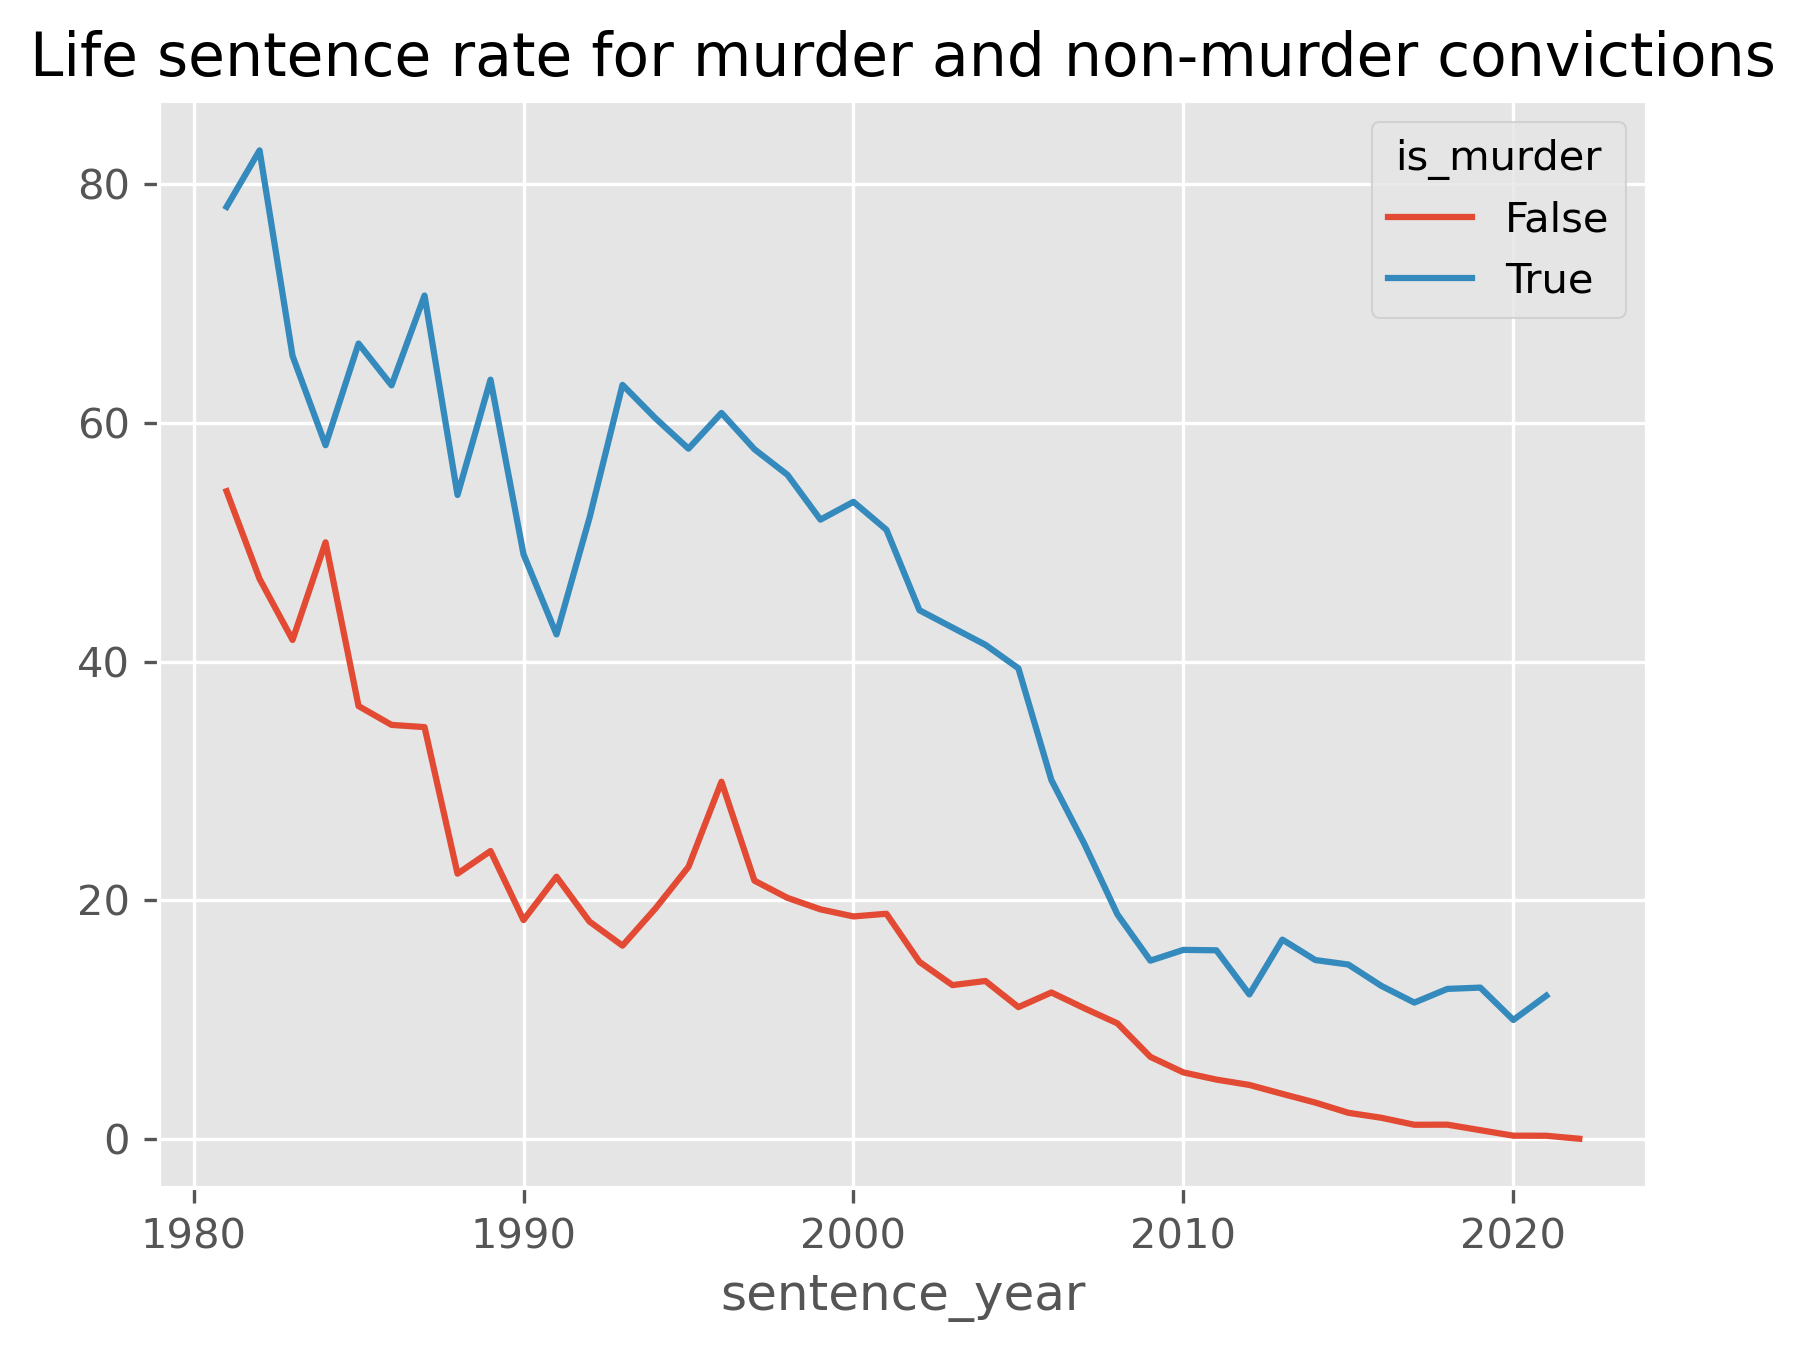

In [4]:
(df
    .query('sentence_year > 1980')
    .pivot_table(
        index='sentence_year',
        columns='is_murder',
        values='is_life_sentence'
    )
    .multiply(100)
    .plot.line(title='Life sentence rate for murder and non-murder convictions')
);

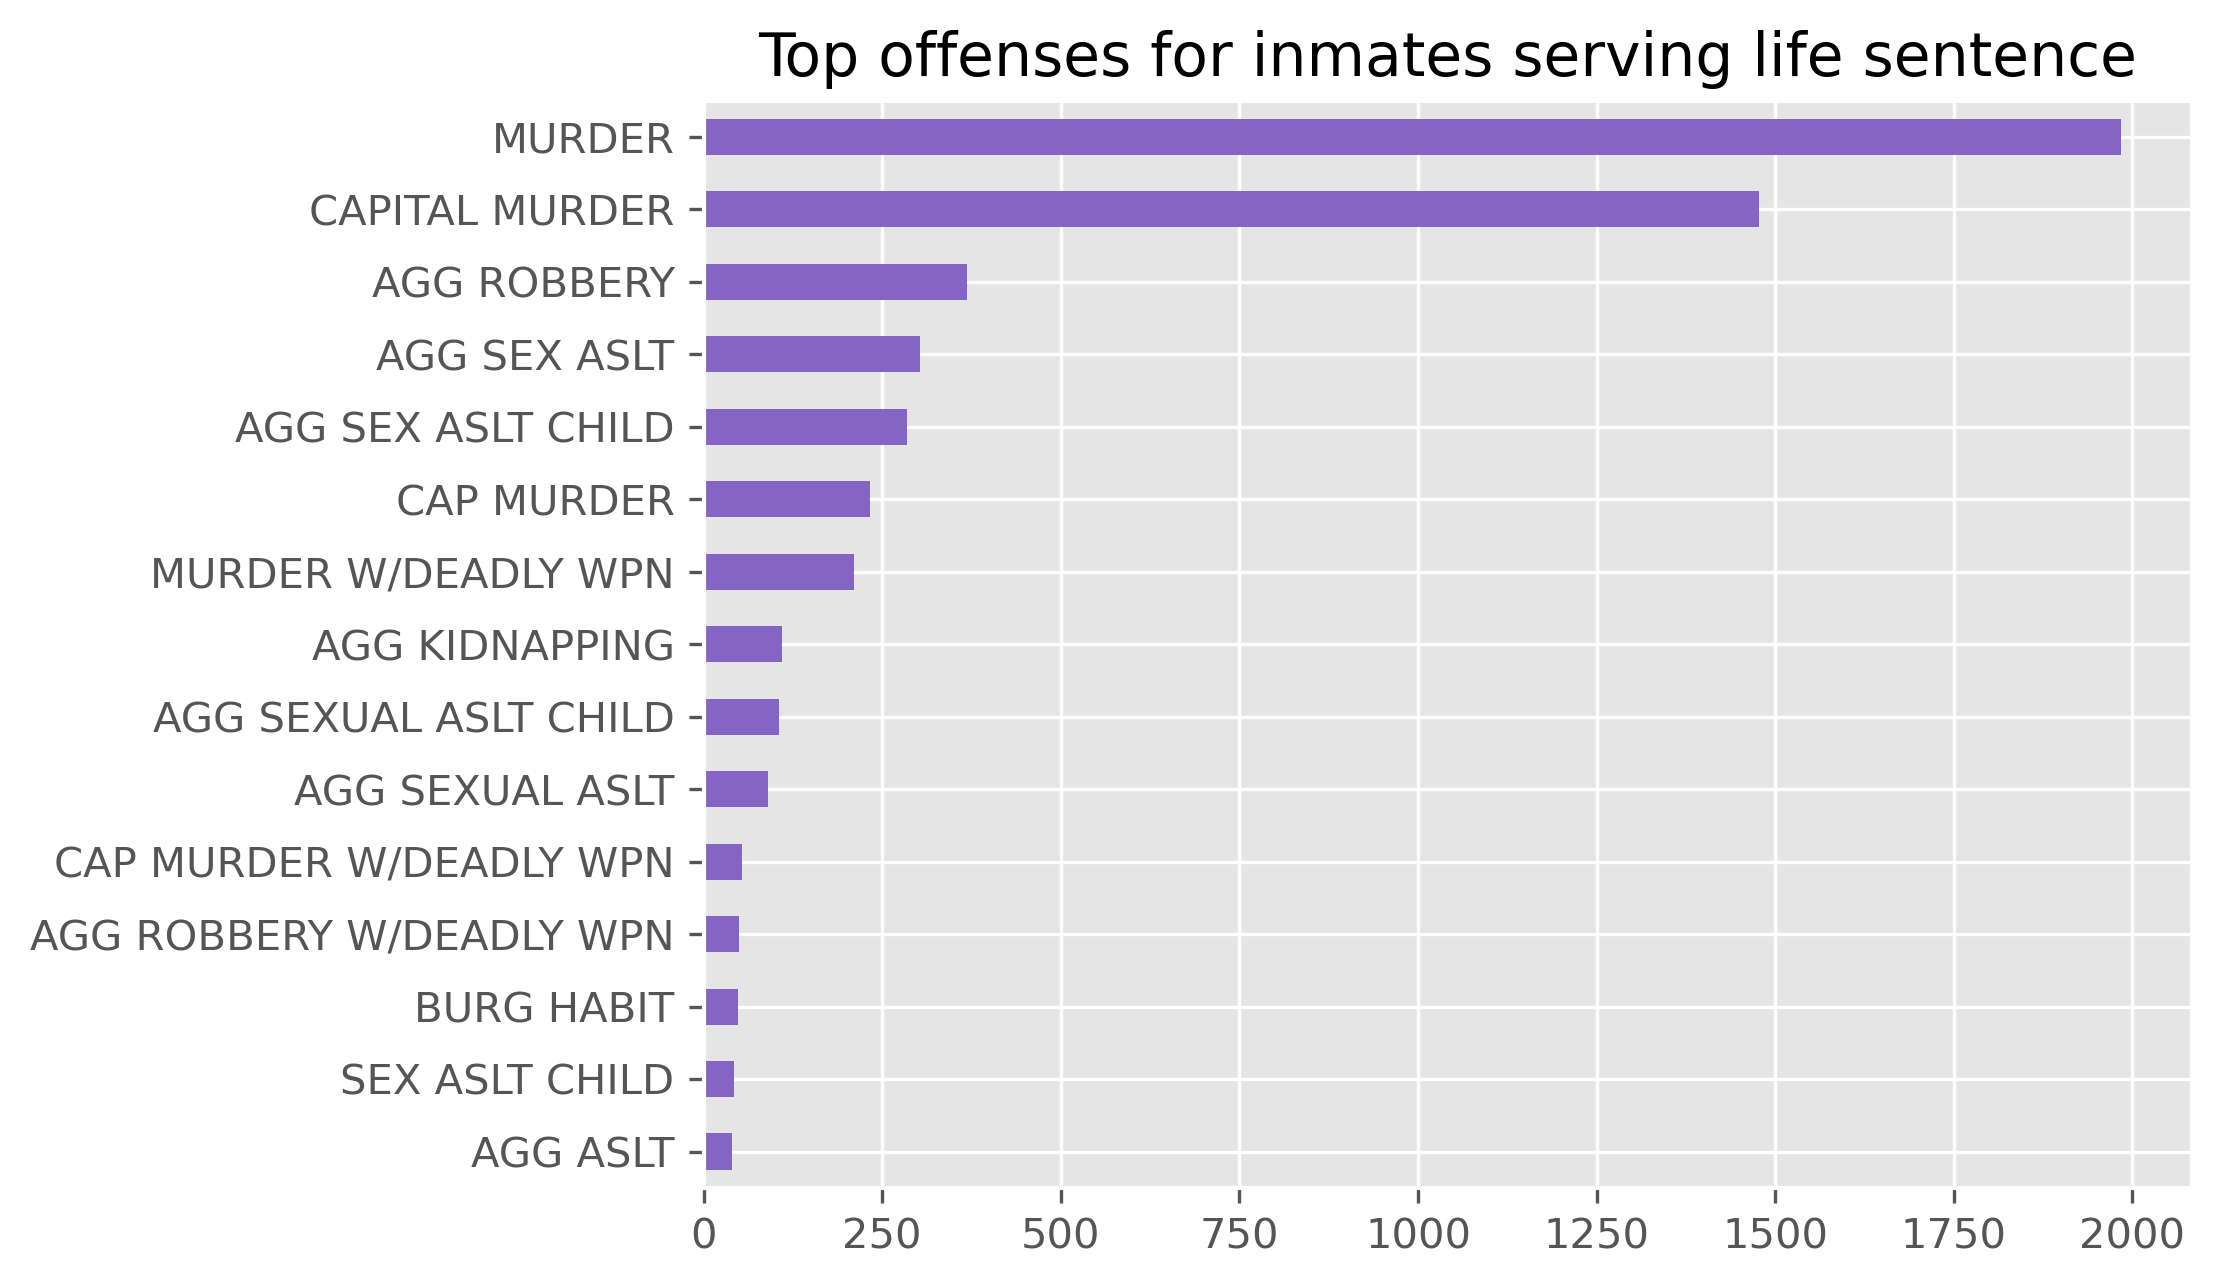

In [5]:
(df
    .query('is_life_sentence == True')
    .tdcj_offense
    .value_counts()
    .head(15)
    .sort_values()
    .plot.barh(title='Top offenses for inmates serving life sentence', color=SOFT_PURPLE)
);

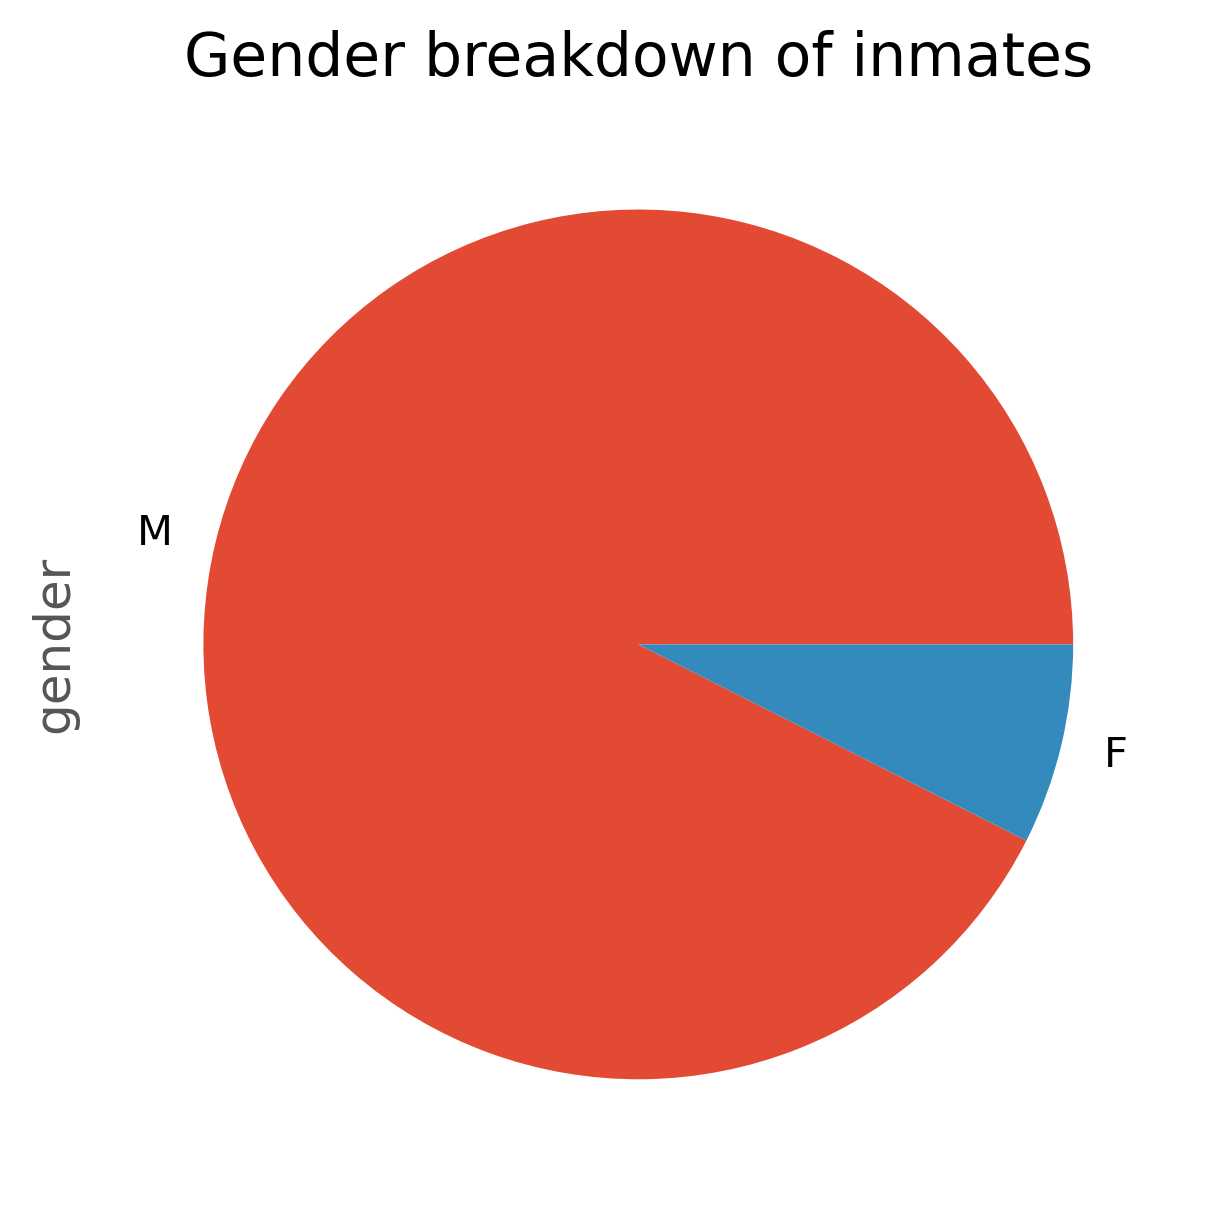

In [6]:
(df
    .gender
    .value_counts(normalize=True)
    .multiply(100)
    .plot.pie(title='Gender breakdown of inmates')
);

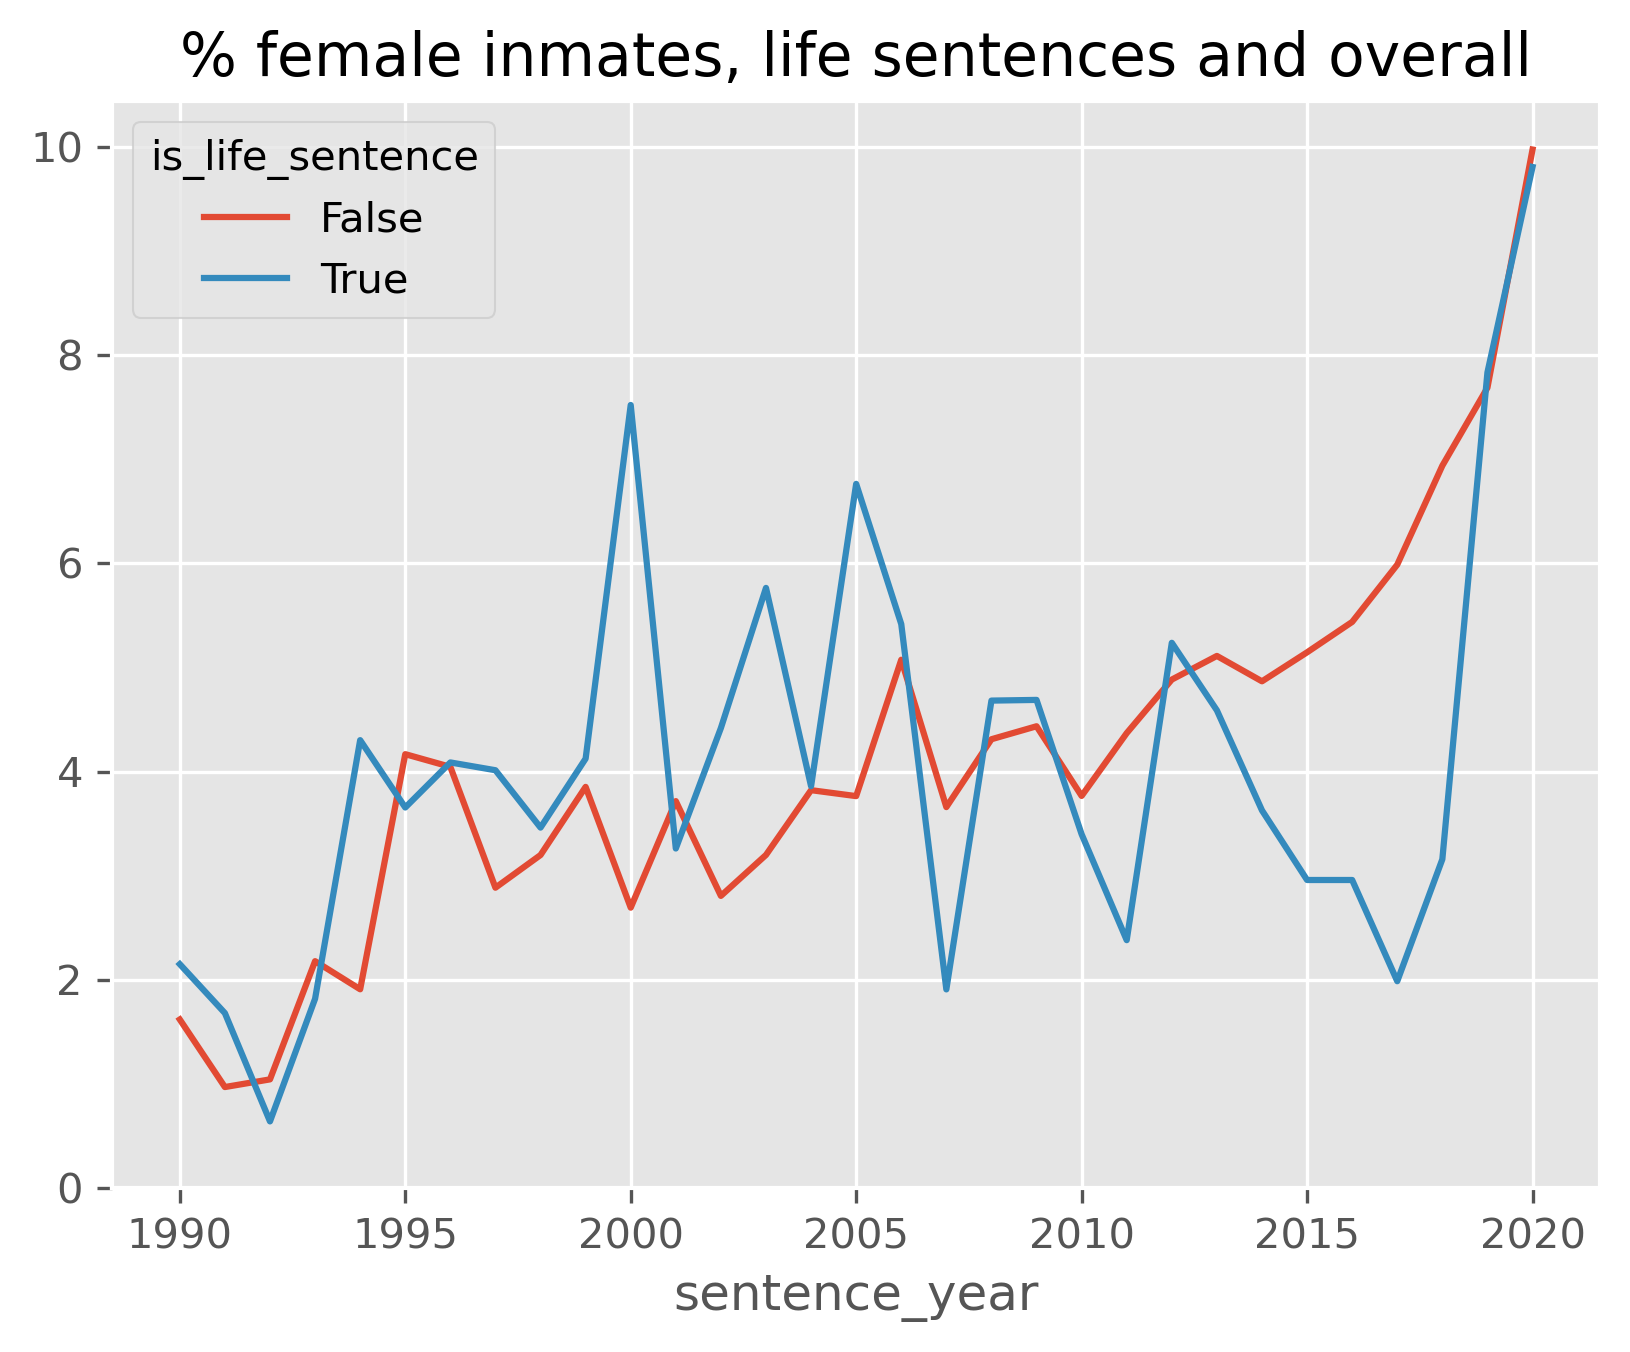

In [7]:
(df
    .query('1990 <= sentence_year <= 2020')
    .pivot_table(index='sentence_year', columns='is_life_sentence', values='is_female')
    .multiply(100)
    .plot.line(title='% female inmates, life sentences and overall', ylim=(0, None))
);

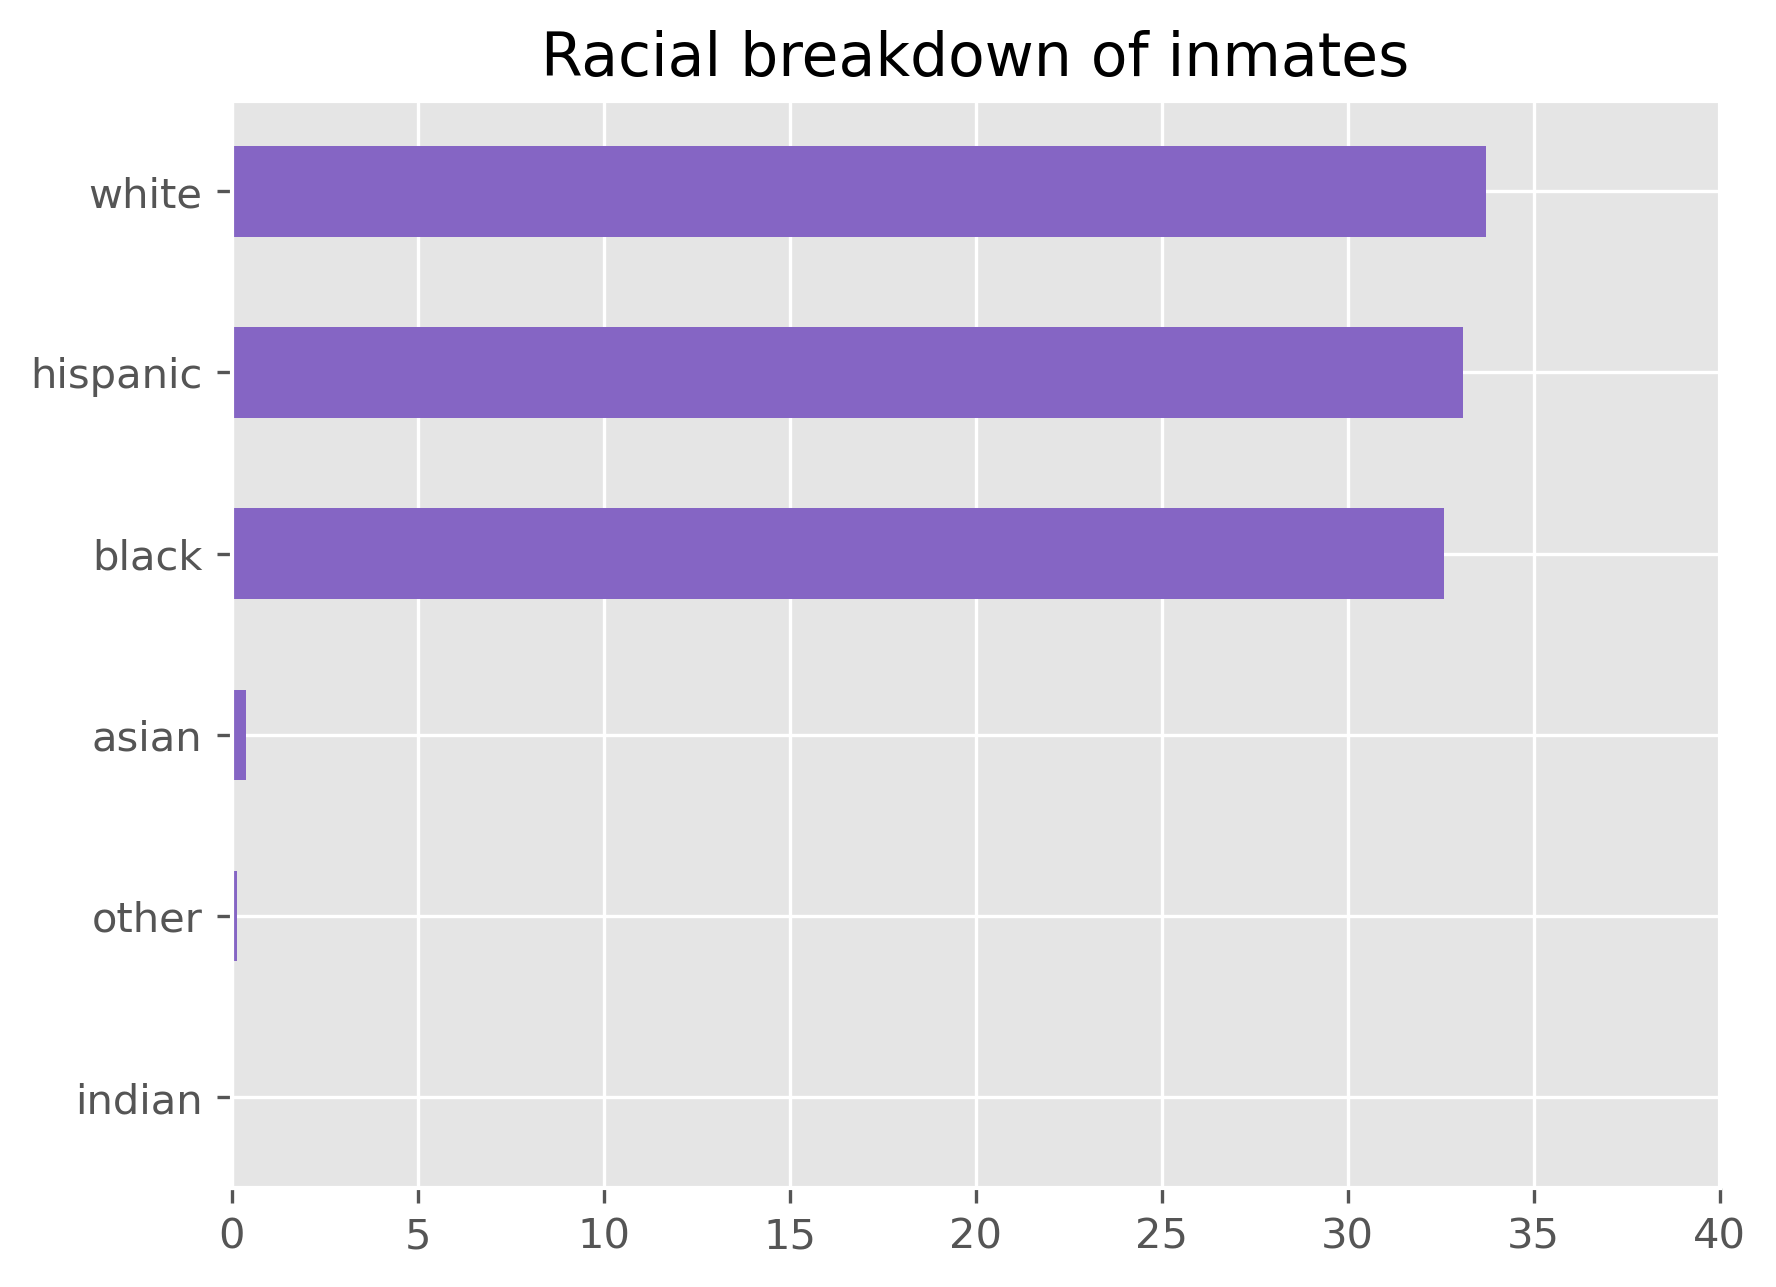

In [8]:
(df
    .race
    .value_counts(normalize=True)
    .sort_values()
    .multiply(100)
    .plot.barh(
        title='Racial breakdown of inmates', 
        xlim=(0, 40), 
        color=SOFT_PURPLE
    )
);

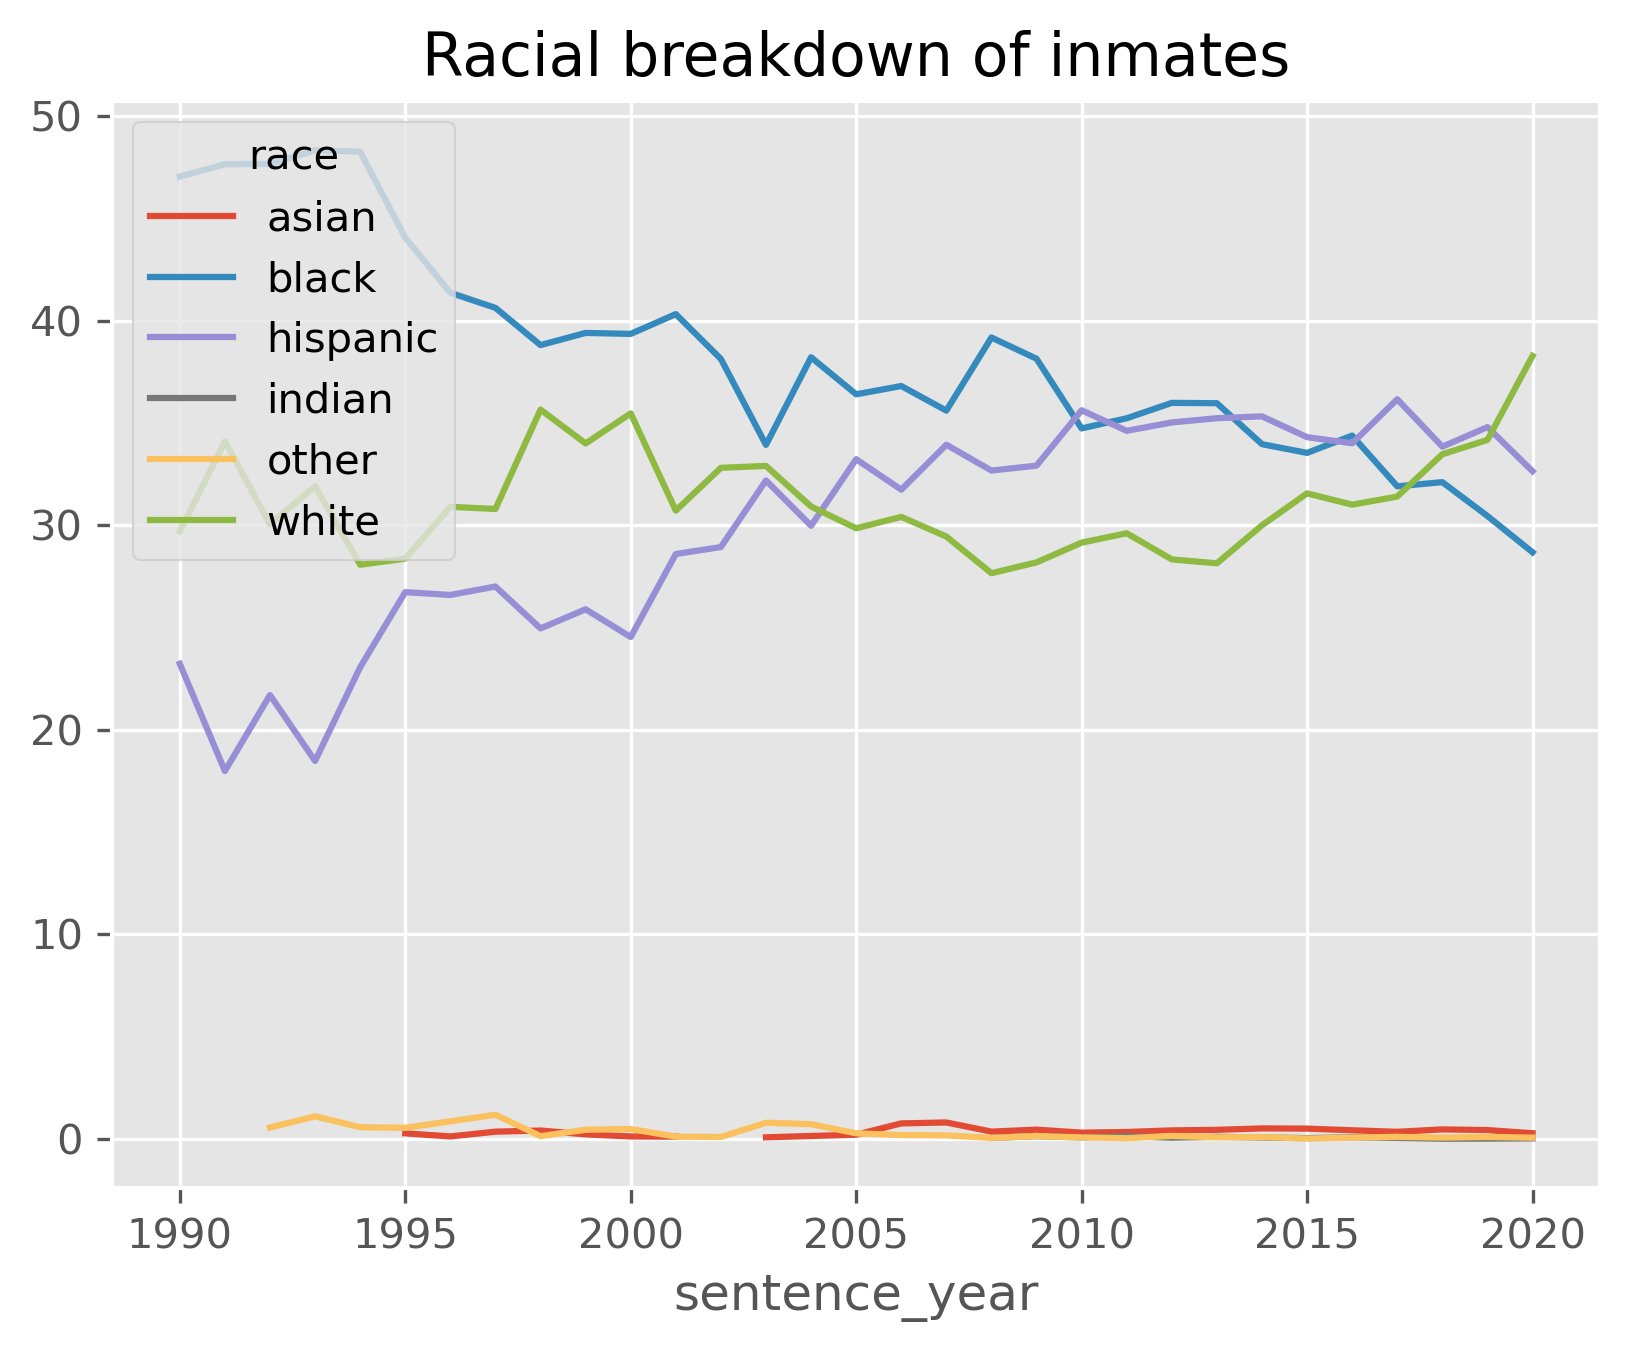

In [9]:
(df
    .query('1990 <= sentence_year <= 2020')
    .groupby('sentence_year')
    .race
    .value_counts(normalize=True)
    .unstack('race')
    .multiply(100)
    .plot.line(title='Racial breakdown of inmates')
);

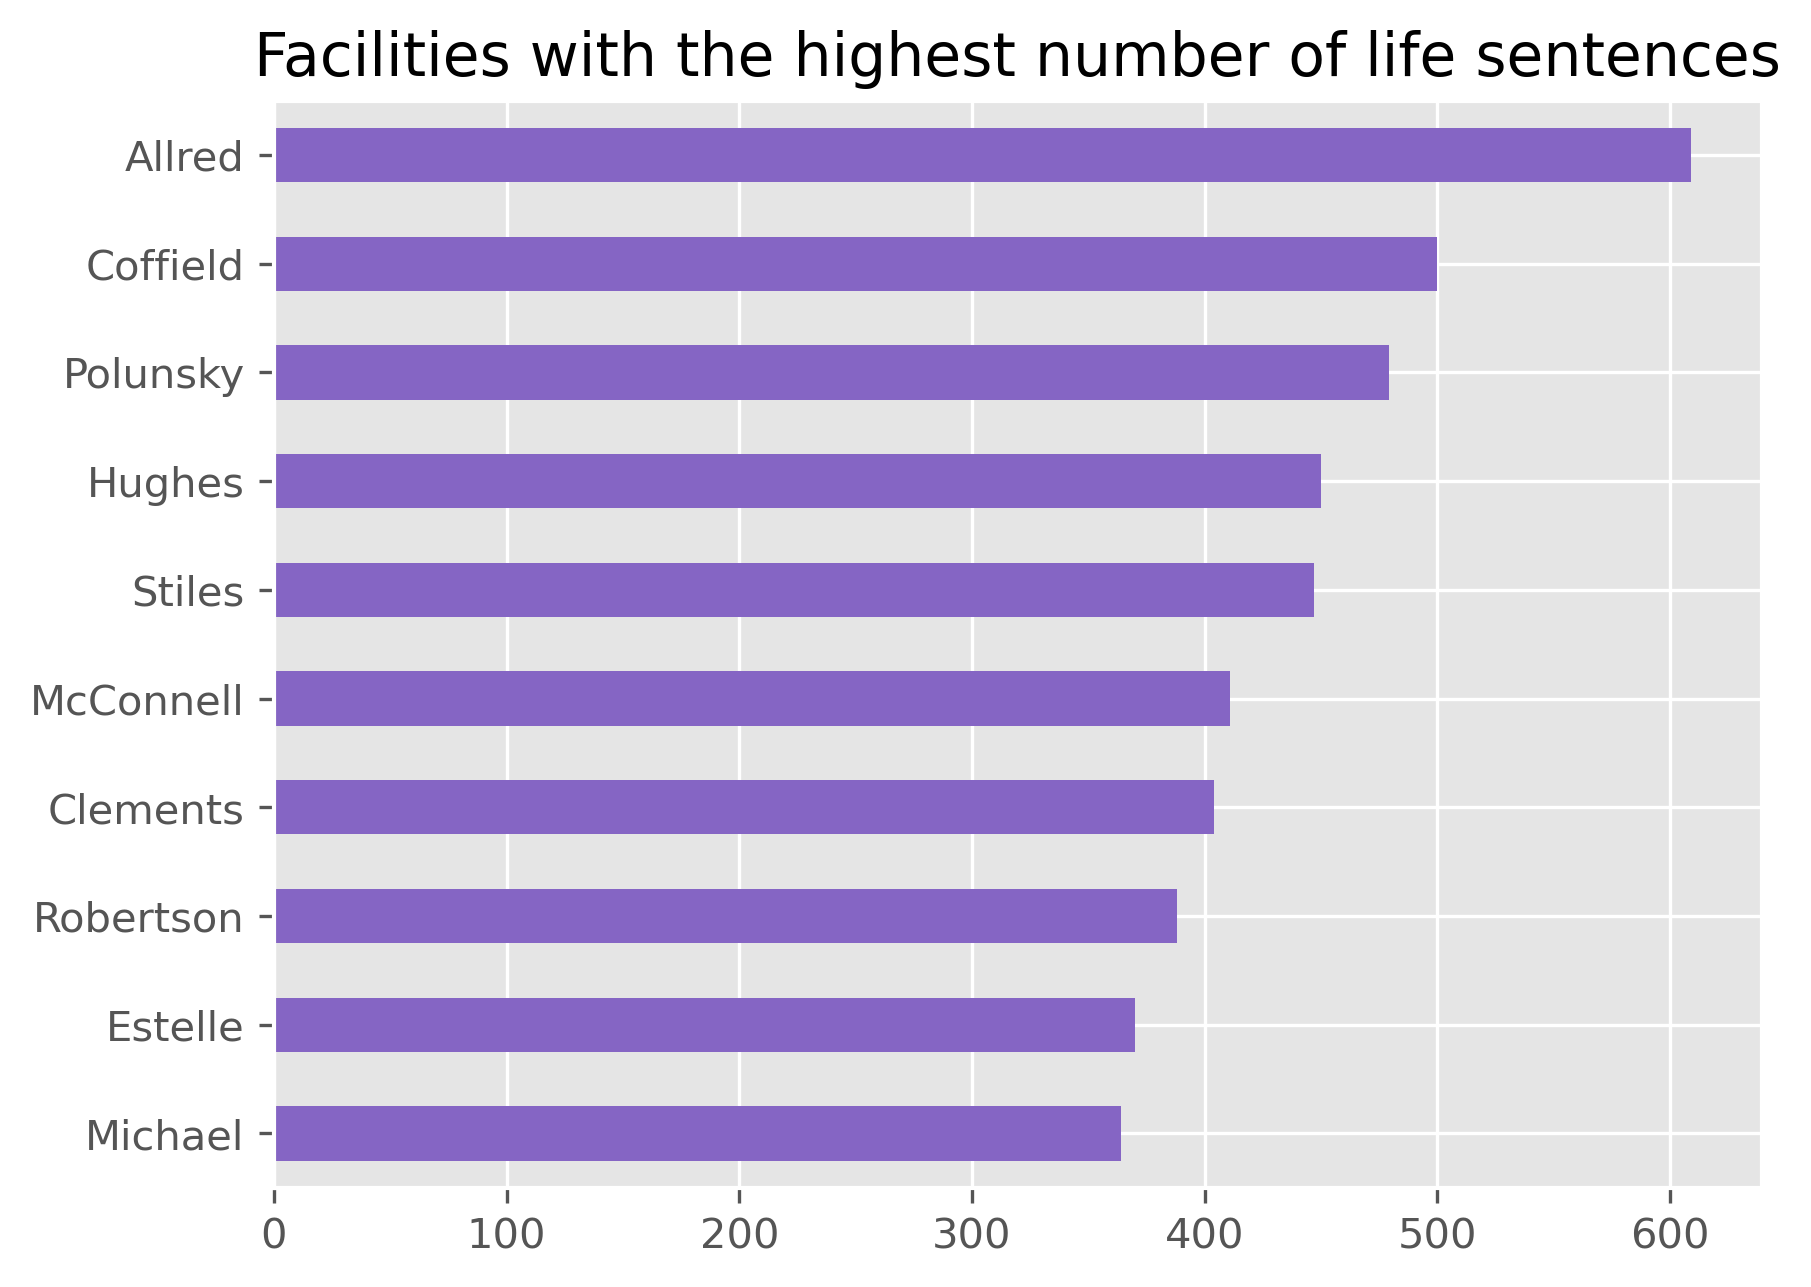

In [10]:
(df
    .query('is_life_sentence == True')
    .current_facility
    .value_counts()
    .head(10)
    .sort_values()
    .plot.barh(
        title='Facilities with the highest number of life sentences',
        color=SOFT_PURPLE
    )
);

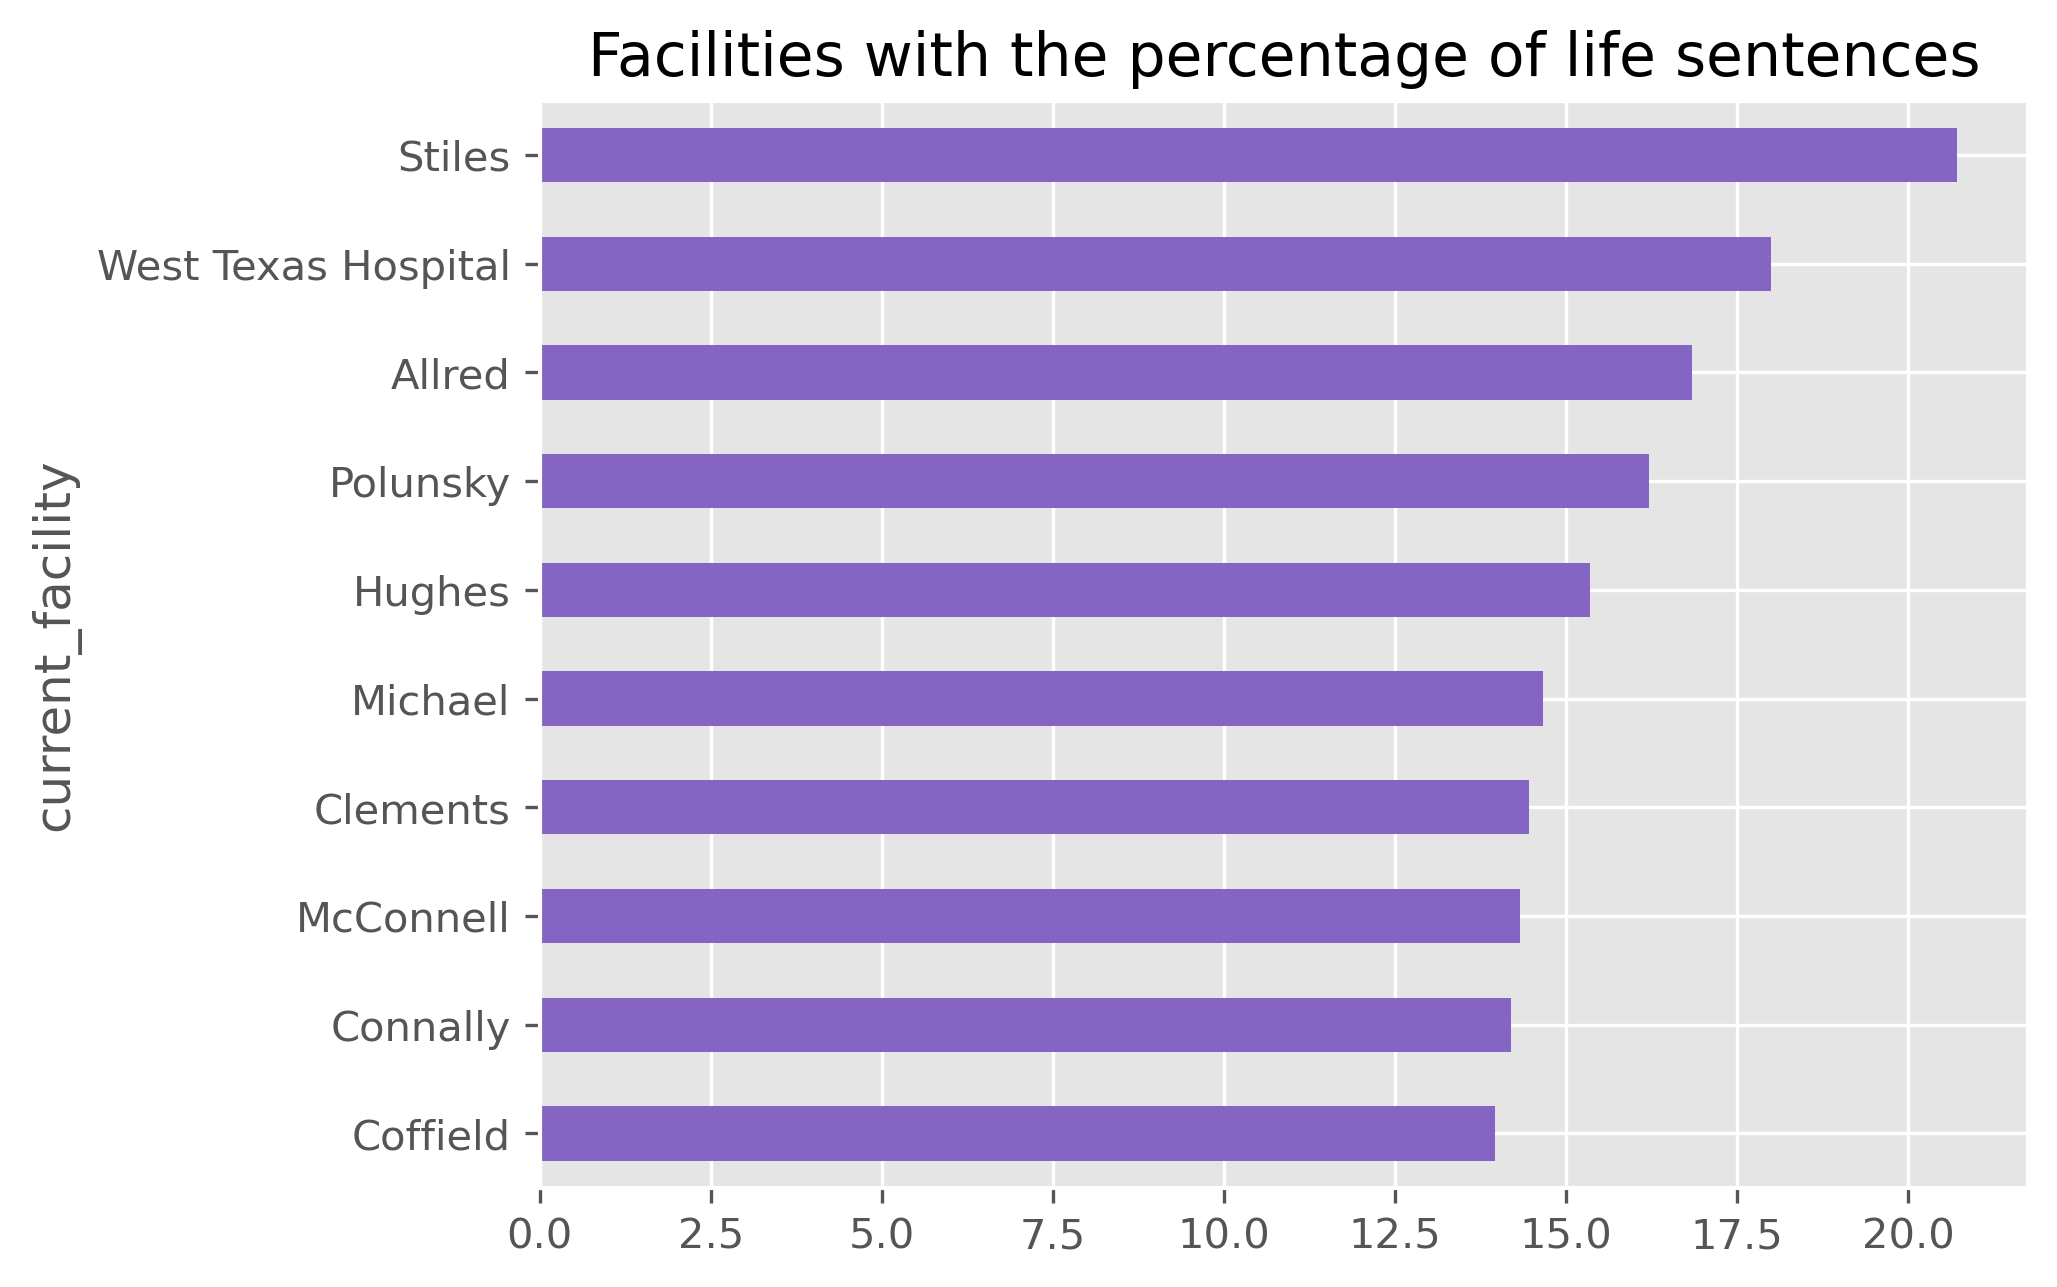

In [11]:
(df
    .groupby('current_facility')
    .is_life_sentence
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .multiply(100)
    .sort_values()
    .plot.barh(
        title='Facilities with the percentage of life sentences',
        color=SOFT_PURPLE
    )
);

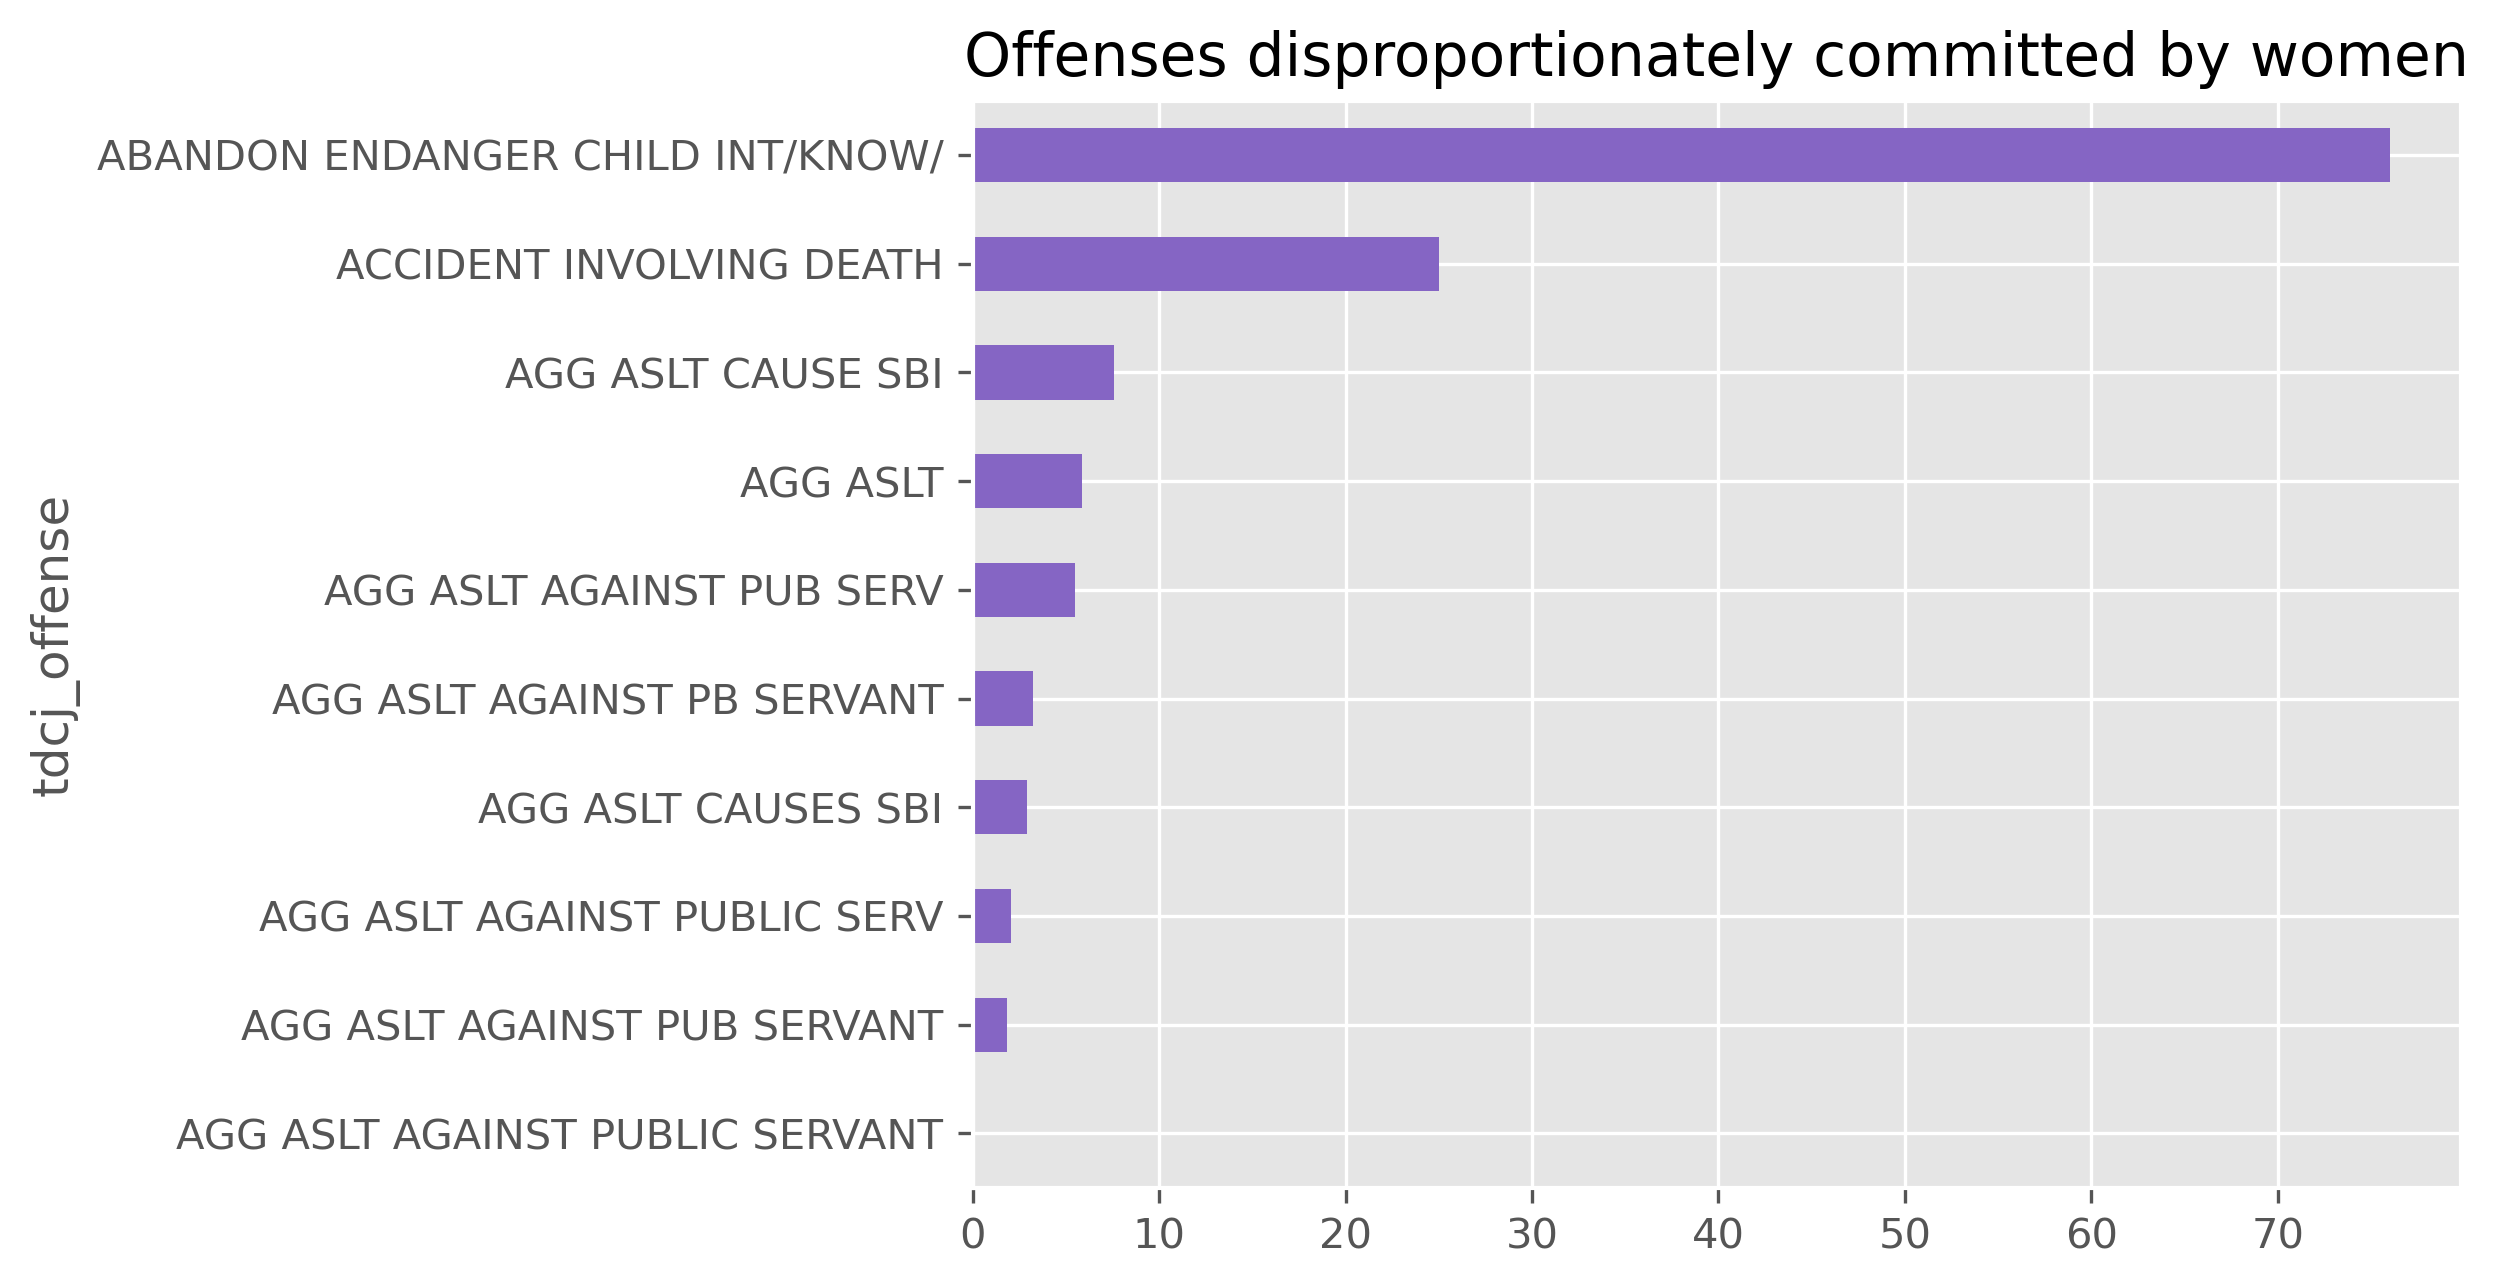

In [12]:
(df
    .groupby('tdcj_offense')
    .agg(
        perc_female=('is_female', np.mean),
        total=('is_female', len)
    )
    .query('total >= 20')   # semi arbitrary threshold
    .head(10)
    .sort_values('perc_female')
    .perc_female
    .multiply(100)
    .plot.barh(
        title='Offenses disproportionately committed by women',
        color=SOFT_PURPLE
    )
);

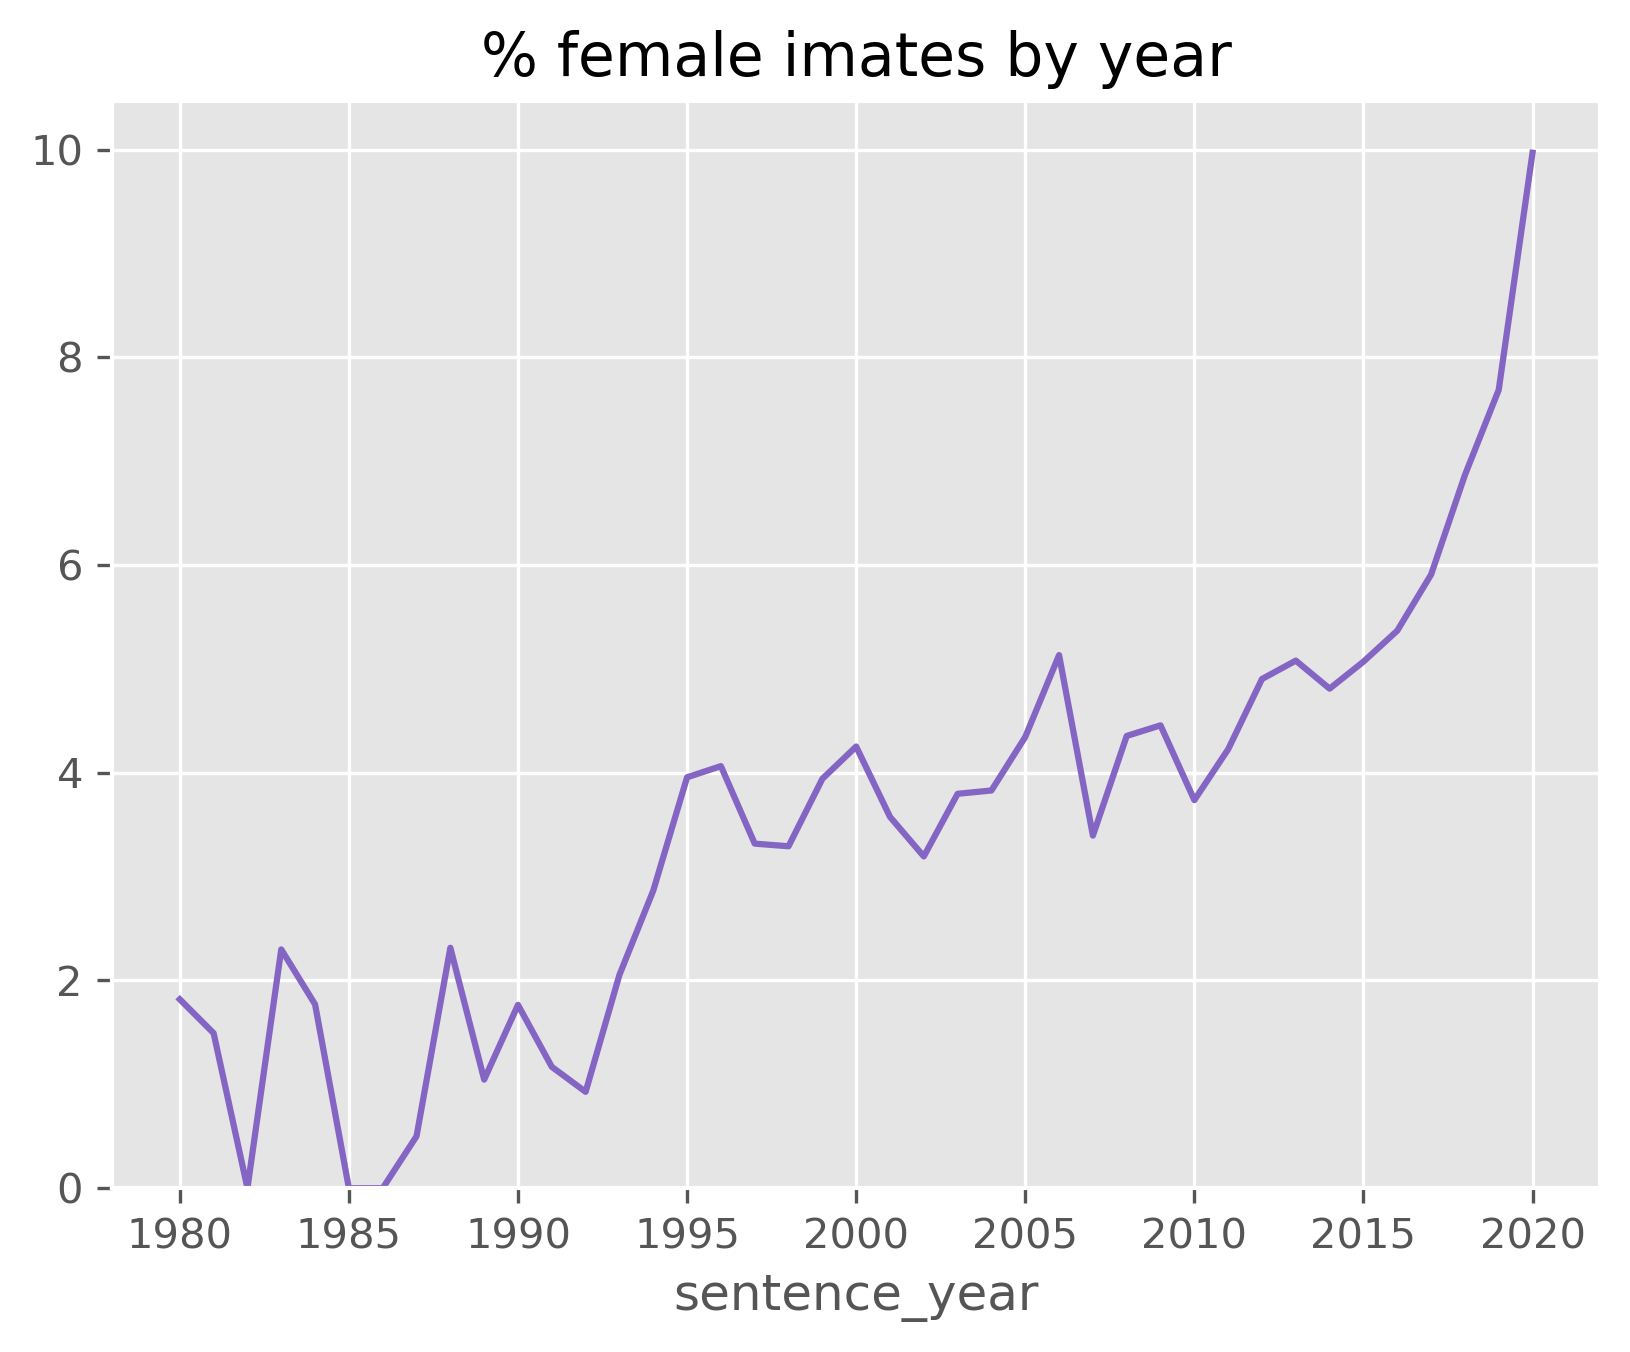

In [13]:
(df
    .query('1980 <= sentence_year <= 2020')
    .groupby('sentence_year')
    .is_female
    .mean()
    .multiply(100)
    .plot.line(
        title='% female imates by year', 
        ylim=(0, None),
        color=SOFT_PURPLE
    )
);

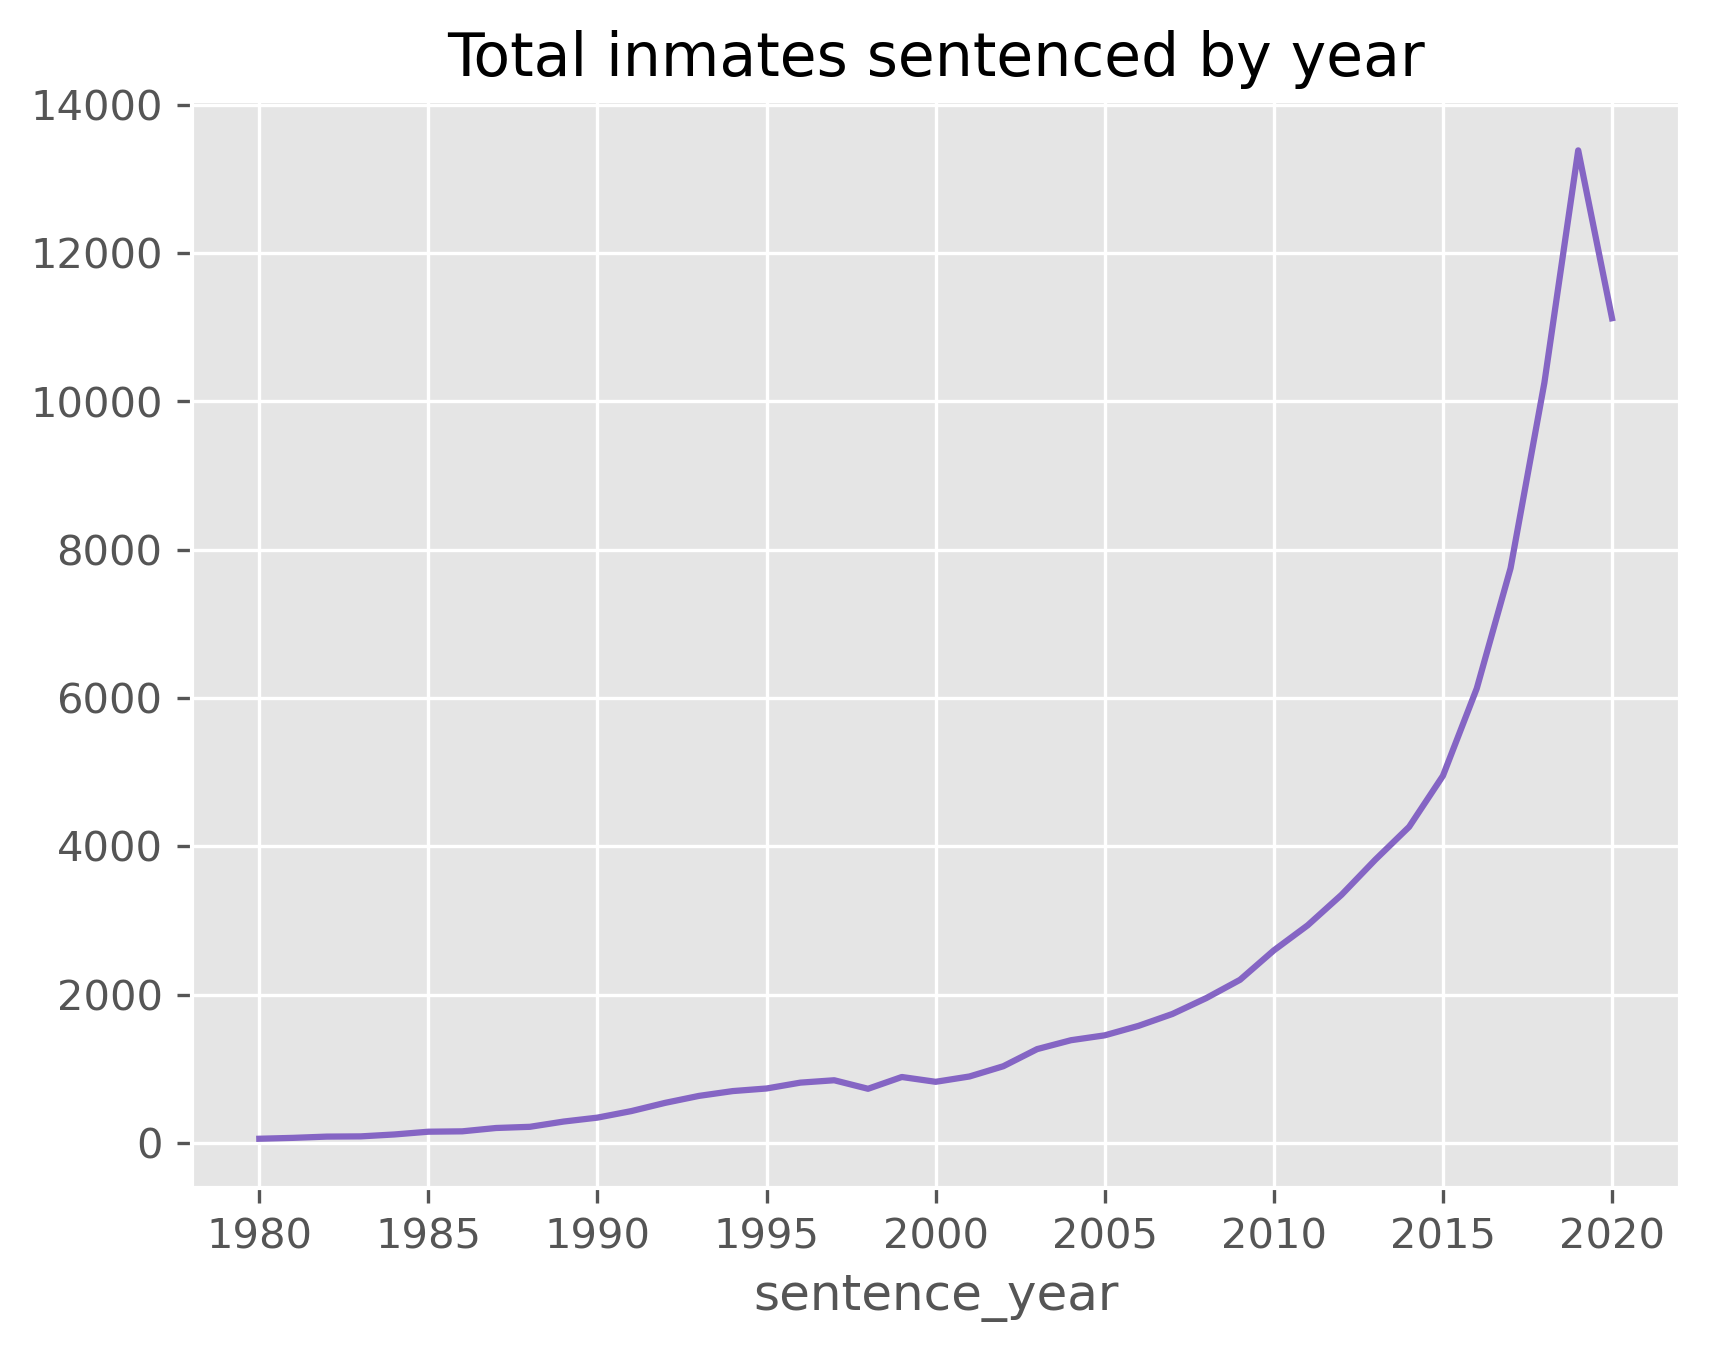

In [14]:
(df
    .query('1980 <= sentence_year <= 2020')
    .groupby('sentence_year')
    .tdcj_number
    .nunique()
    .plot.line(
        title='Total inmates sentenced by year', 
        color=SOFT_PURPLE
    )
);

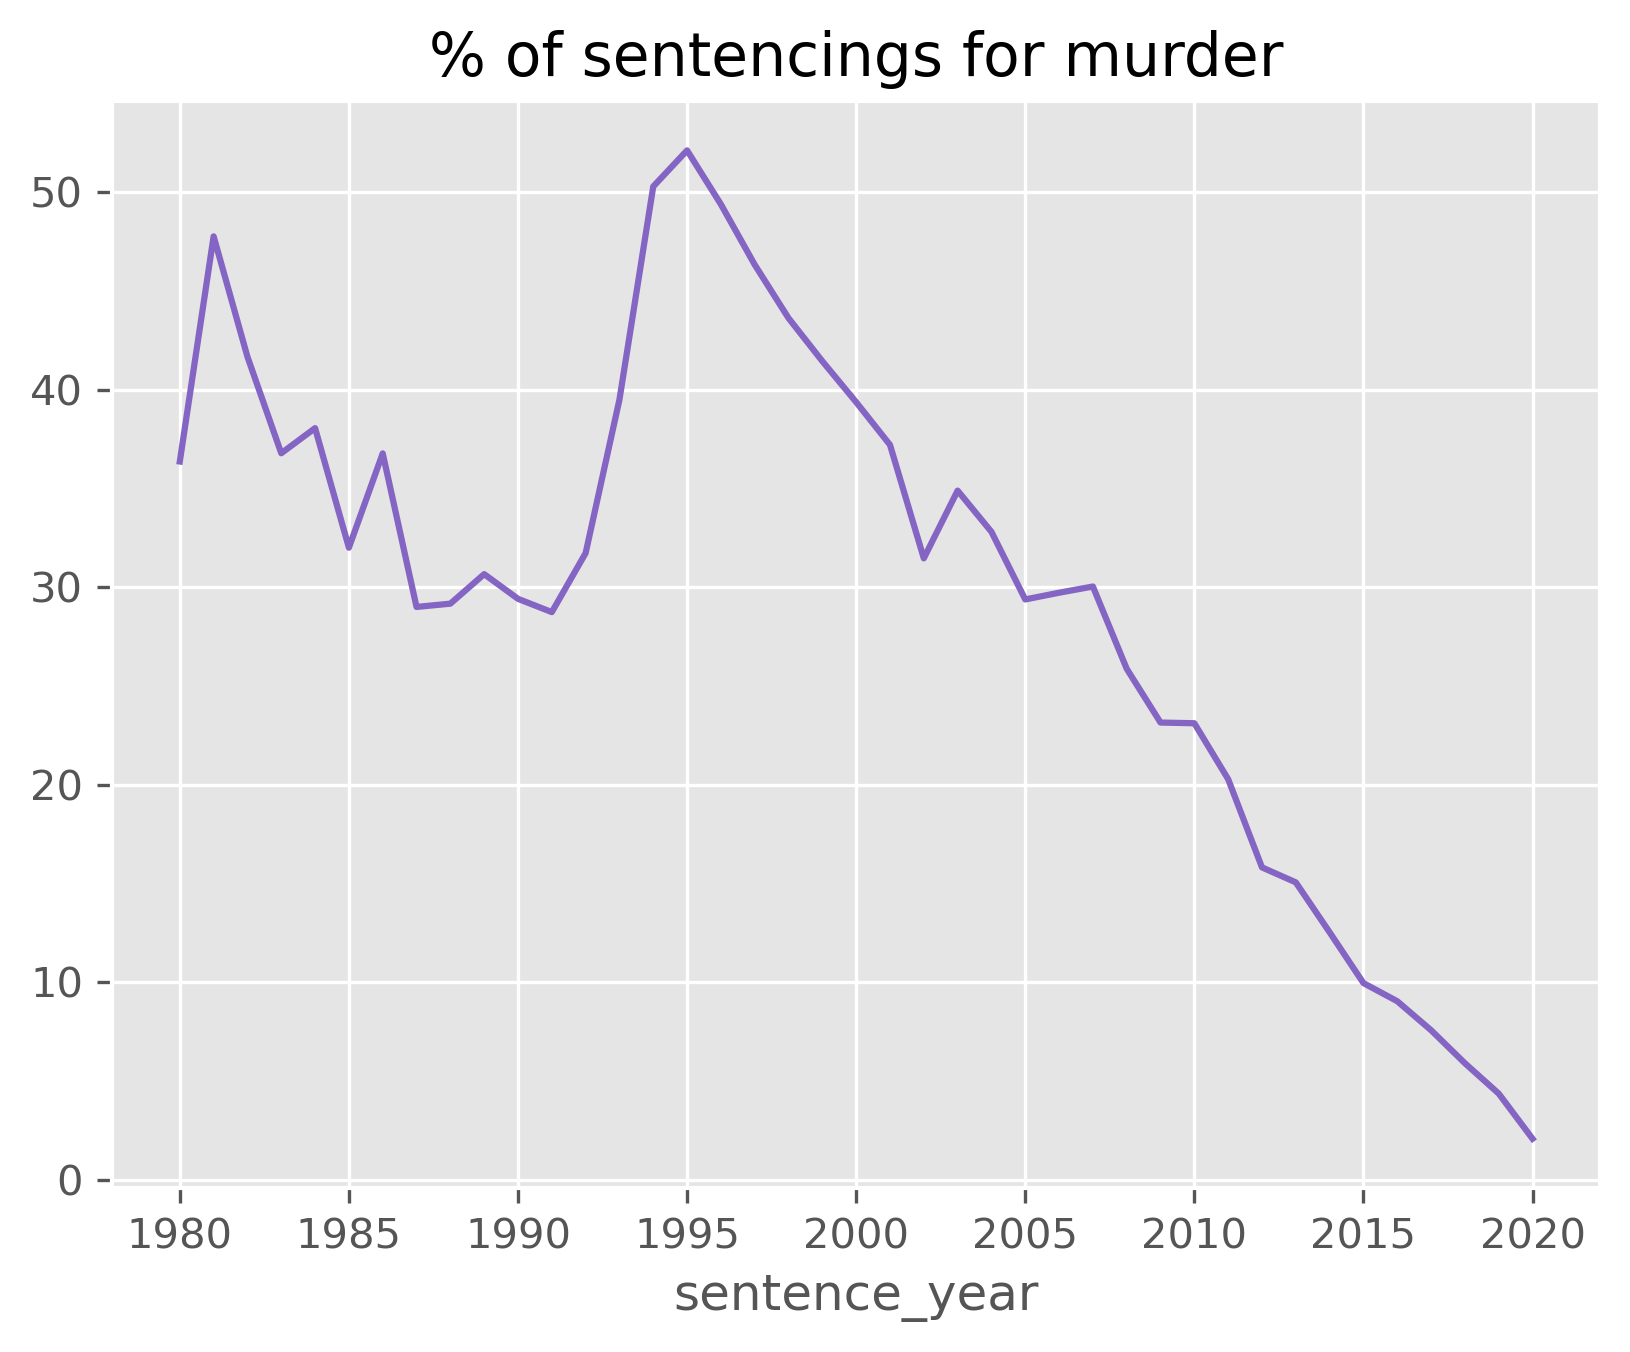

In [15]:
(df
    .query('1980 <= sentence_year <= 2020')
    .groupby('sentence_year')
    .is_murder
    .mean()
    .multiply(100)
    .plot.line(
        title='% of sentencings for murder',
        color=SOFT_PURPLE
    )
);

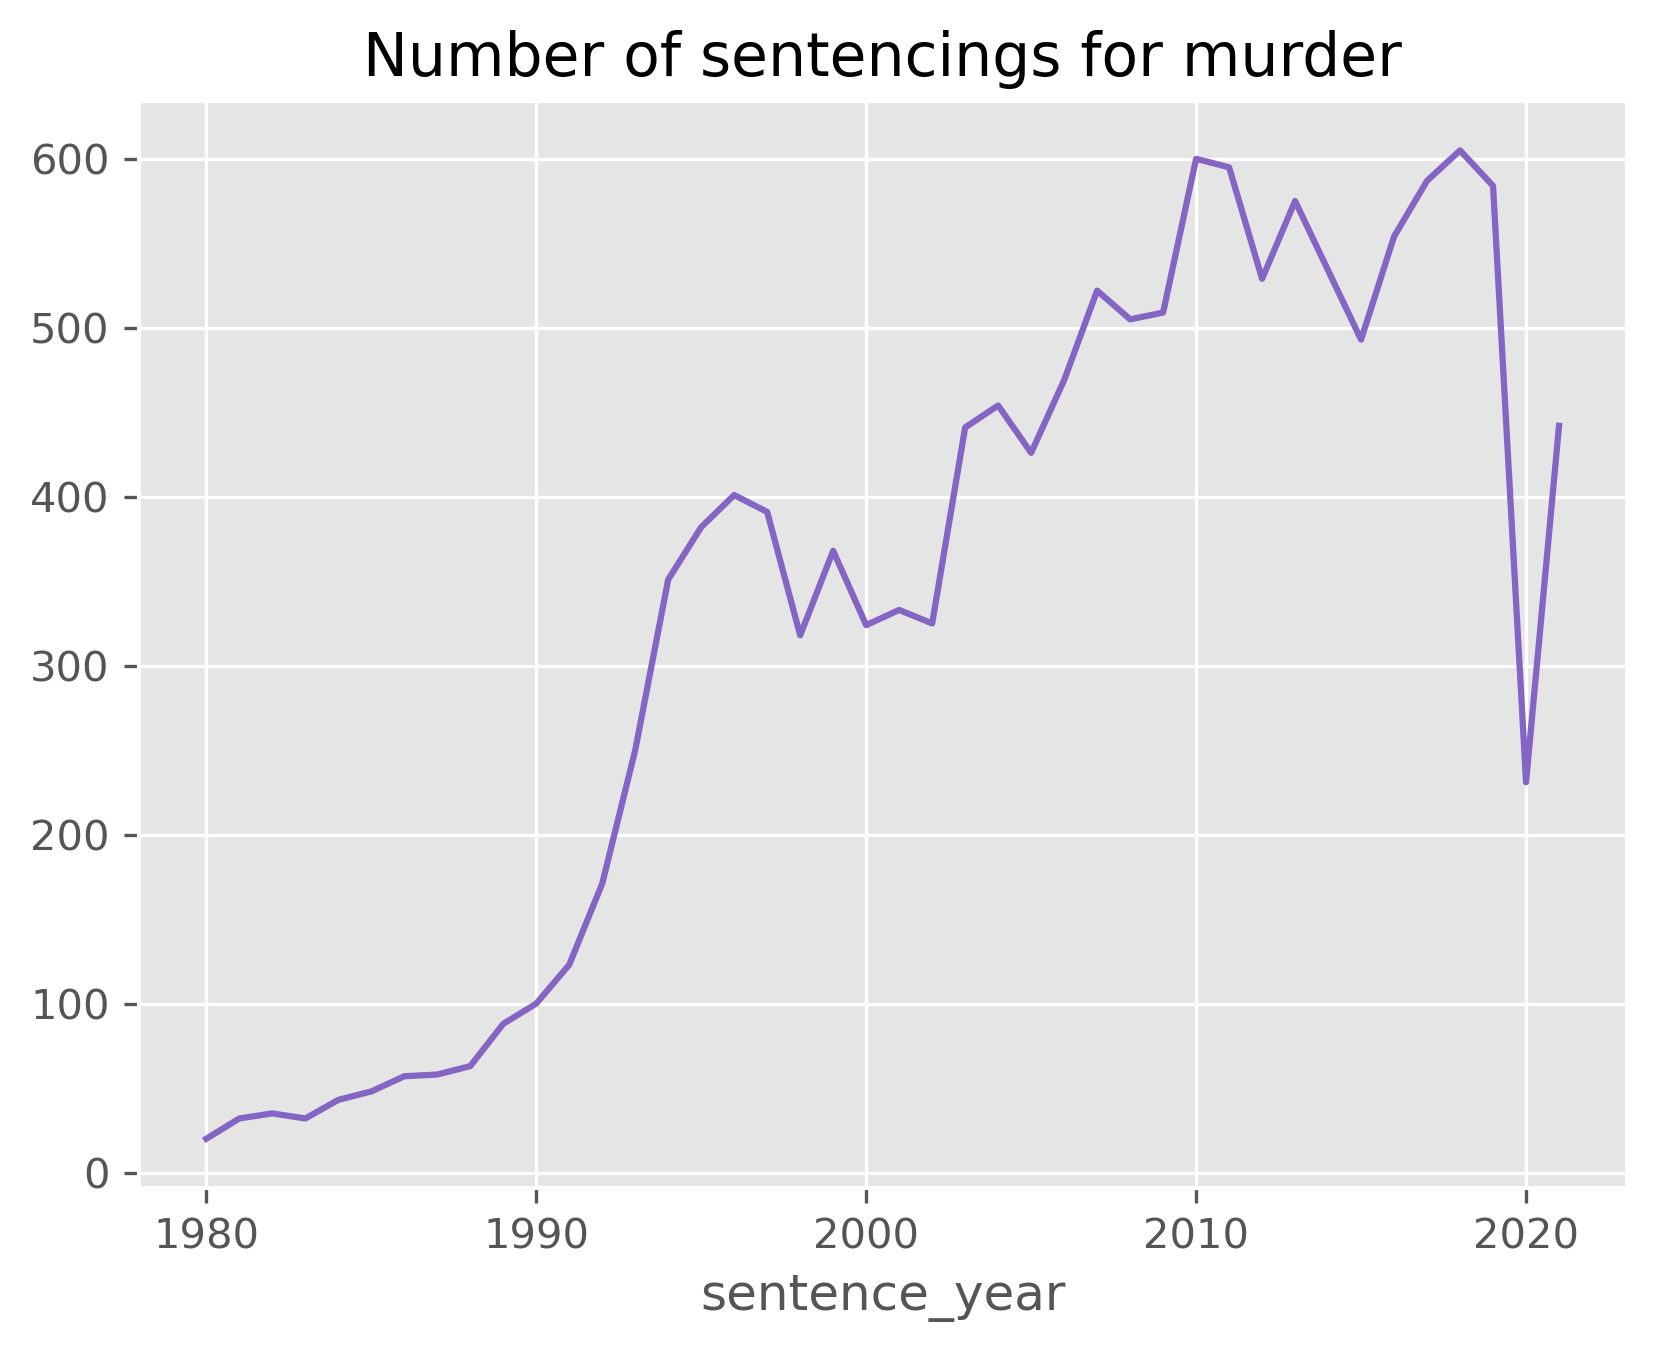

In [16]:
(df
    .query('1980 <= sentence_year <= 2021')
    .groupby('sentence_year')
    .is_murder
    .sum()
    .plot.line(
        title='Number of sentencings for murder',
        color=SOFT_PURPLE
    )
);

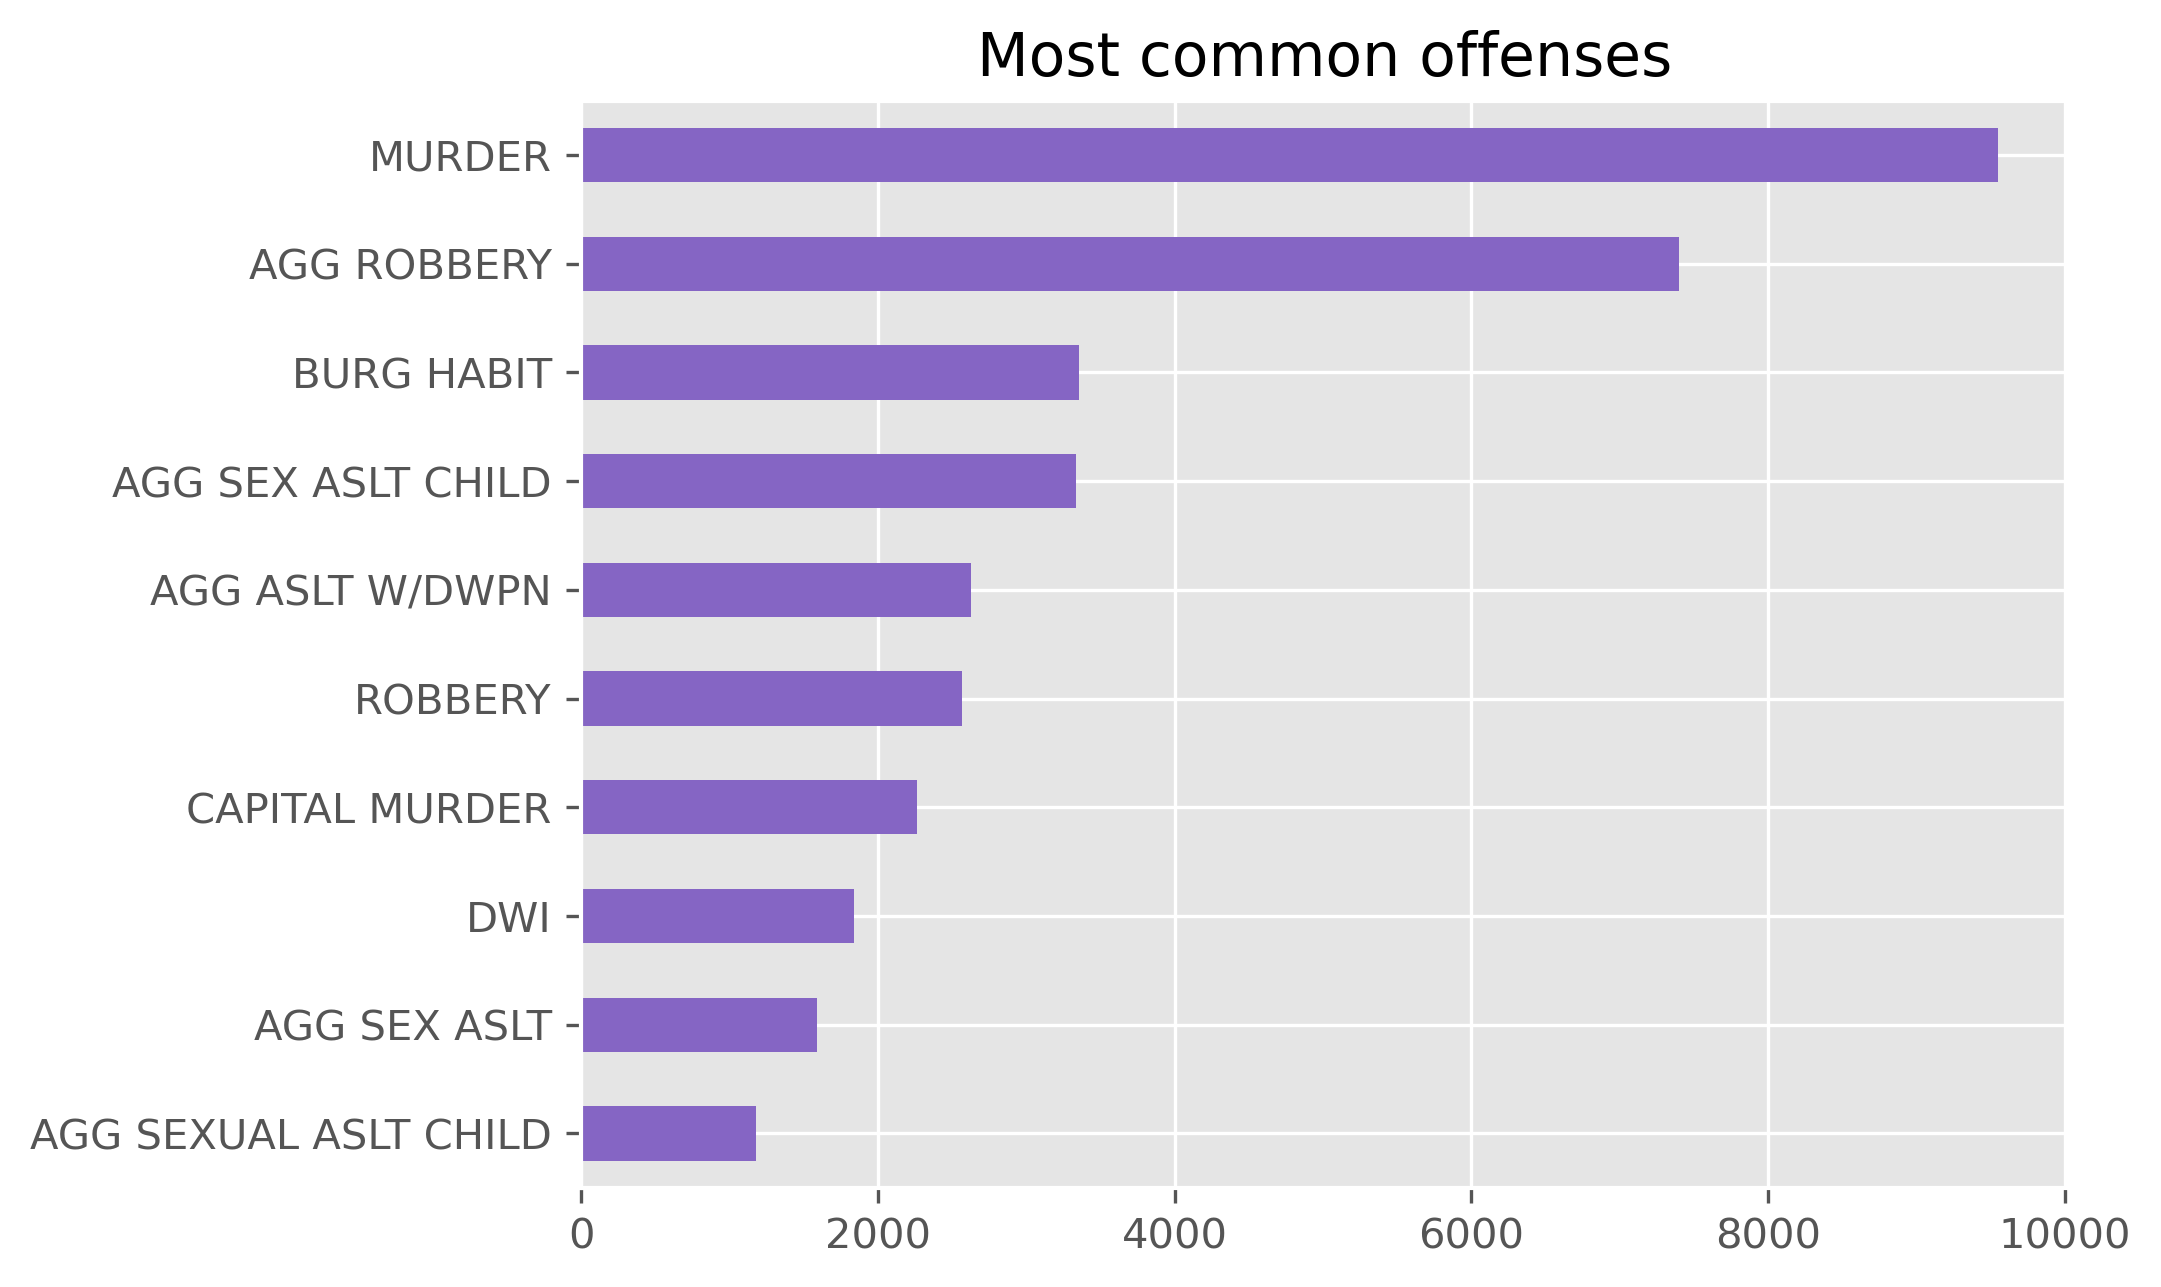

In [17]:
(df
    .tdcj_offense
    .value_counts()
    .head(10)
    .sort_values(ascending=True)
    .plot.barh(title='Most common offenses', color=SOFT_PURPLE)
);

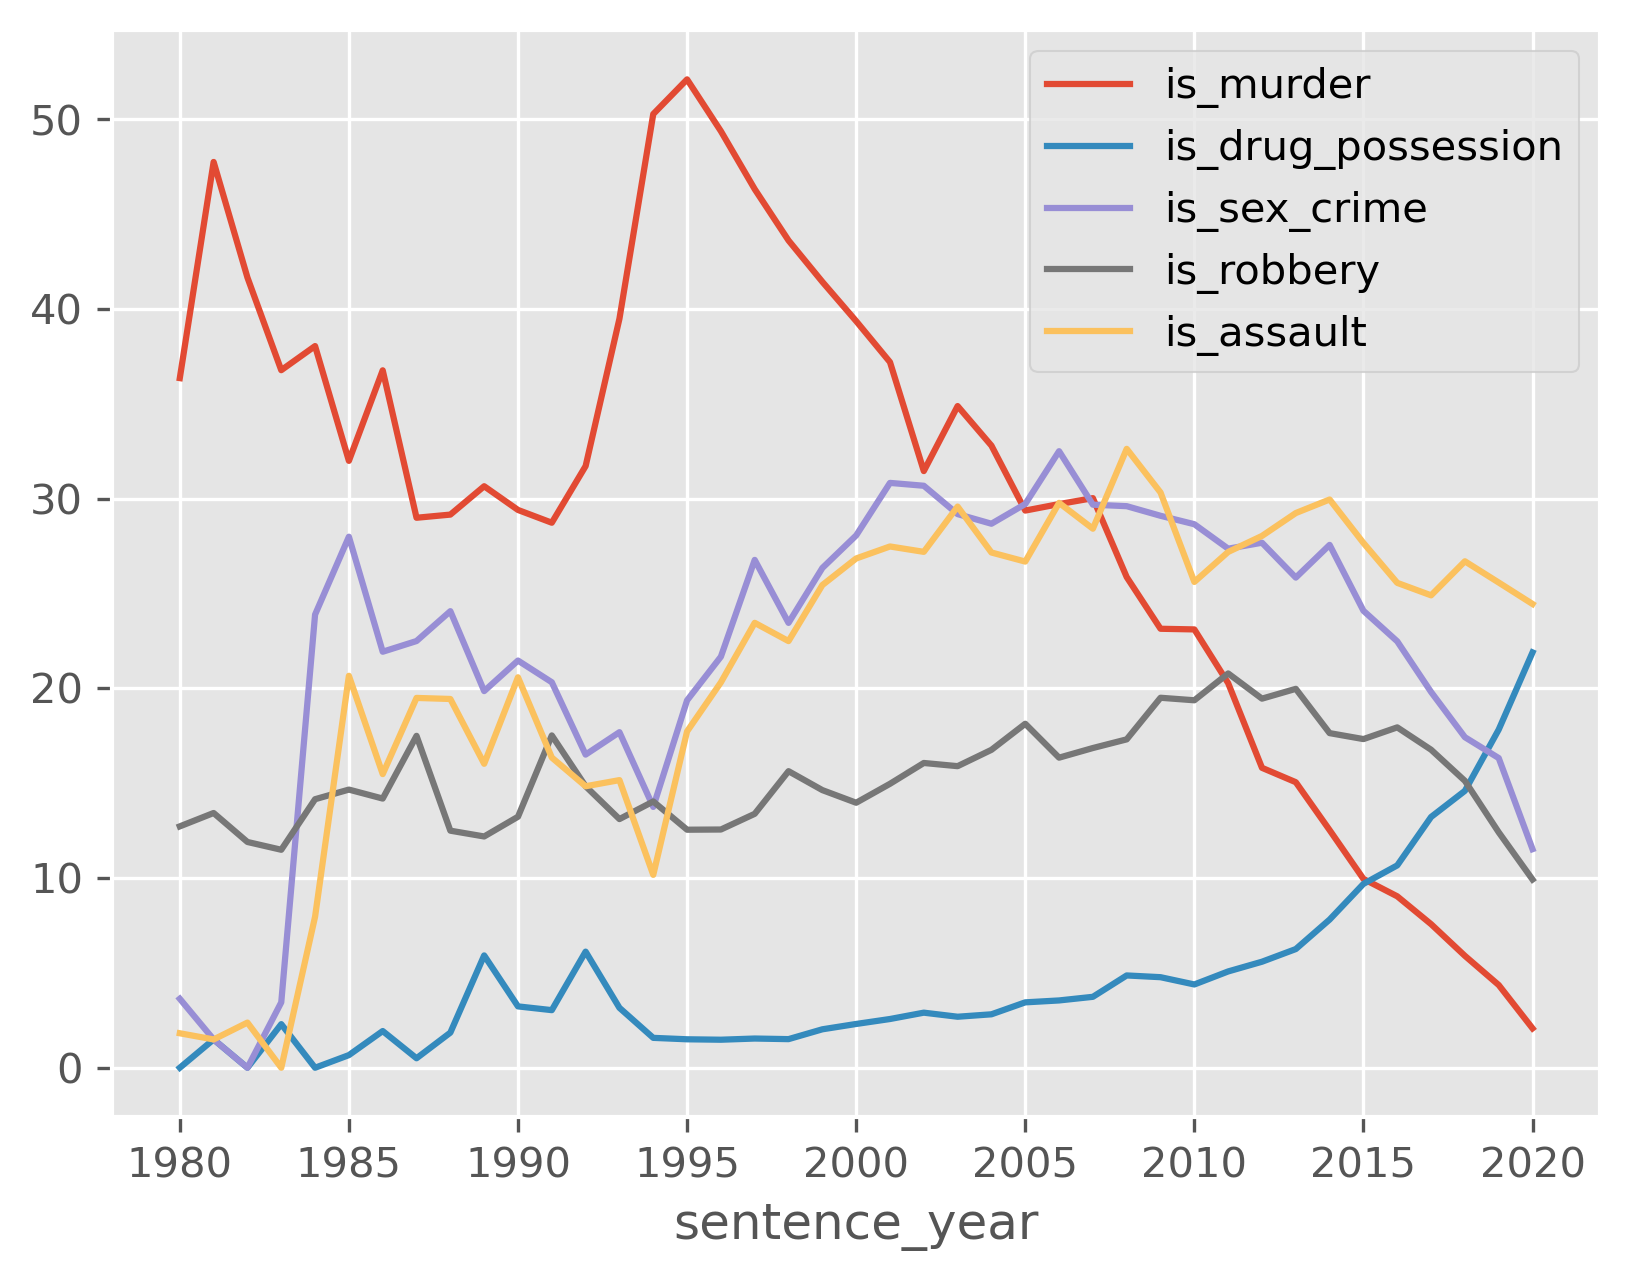

In [18]:
(df
    [[
        'sentence_year', 
        'is_murder', 
        'is_drug_possession', 
        'is_sex_crime', 
        'is_robbery', 
        'is_assault'
     ]]
    .query('1980 <= sentence_year <= 2020')
    .groupby('sentence_year')
    .mean()
    .multiply(100)
    .plot.line()
);

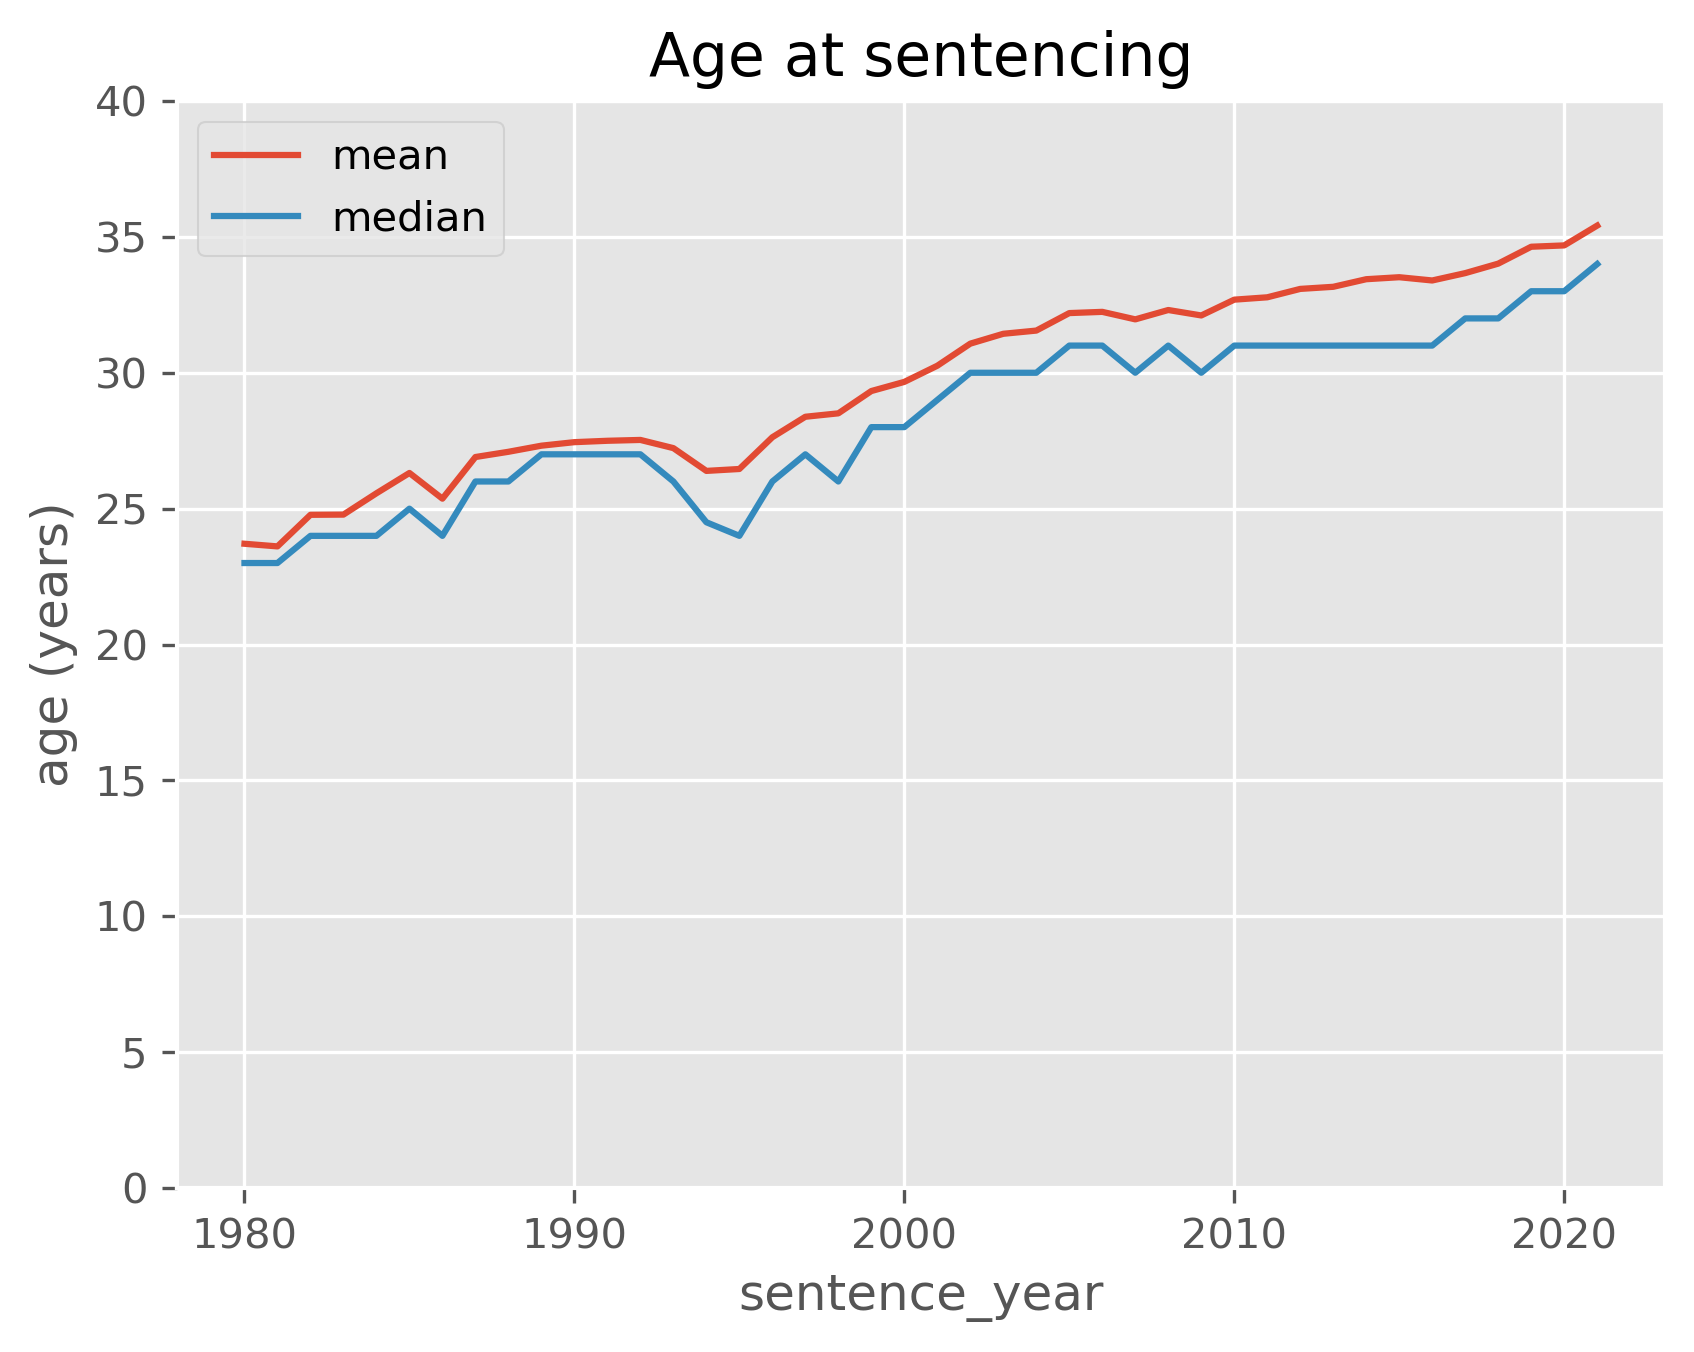

In [19]:
(df
    .query('1980 <= sentence_year <= 2021')
    .groupby('sentence_year')
    .agg(
        mean=('age_at_sentencing', np.mean),
        median=('age_at_sentencing', np.median),
    )
    .plot.line(
        title='Age at sentencing', 
        ylim=(0, 40),
        ylabel='age (years)'
    )
);

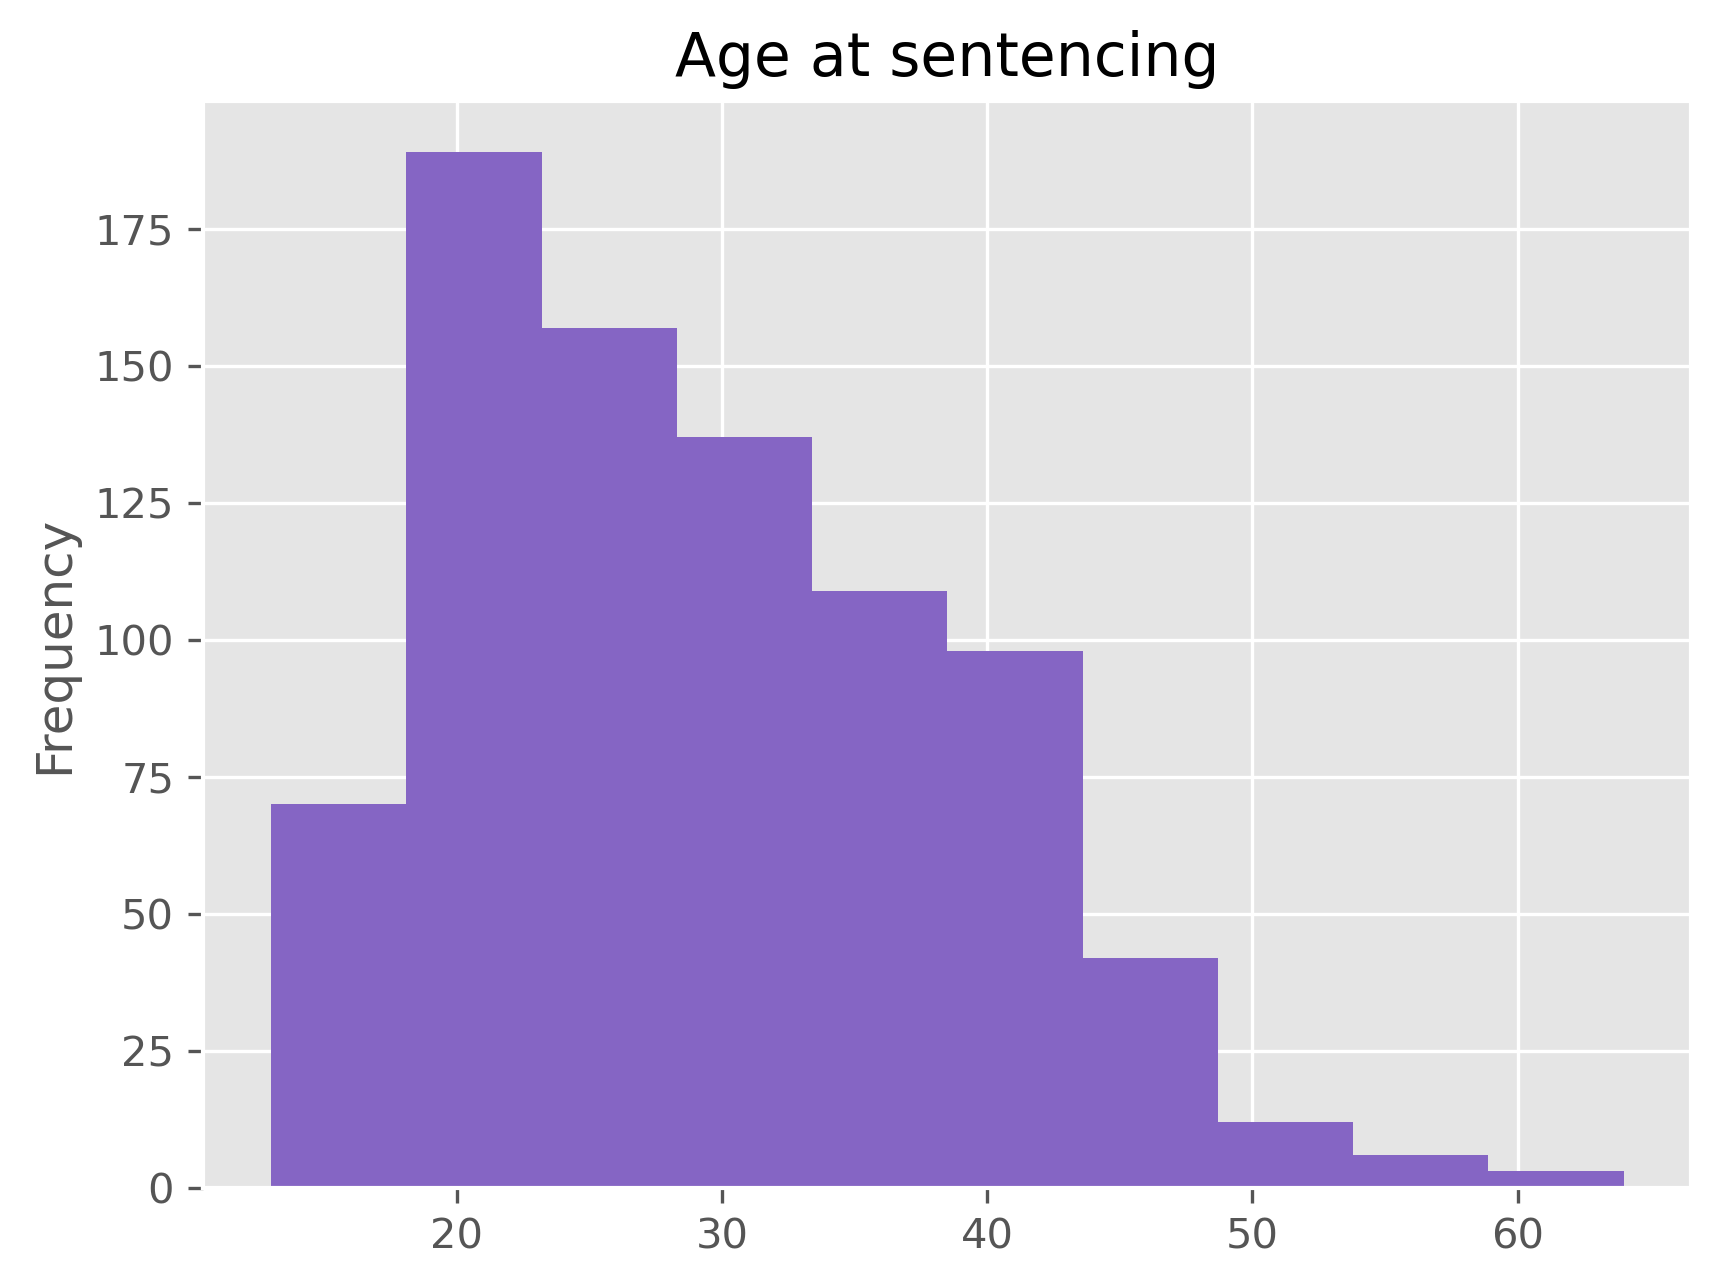

In [20]:
(df
    .query('sentence_year == 2000')
    .age_at_sentencing
    .plot.hist(
        title='Age at sentencing',
        color=SOFT_PURPLE
    )
);

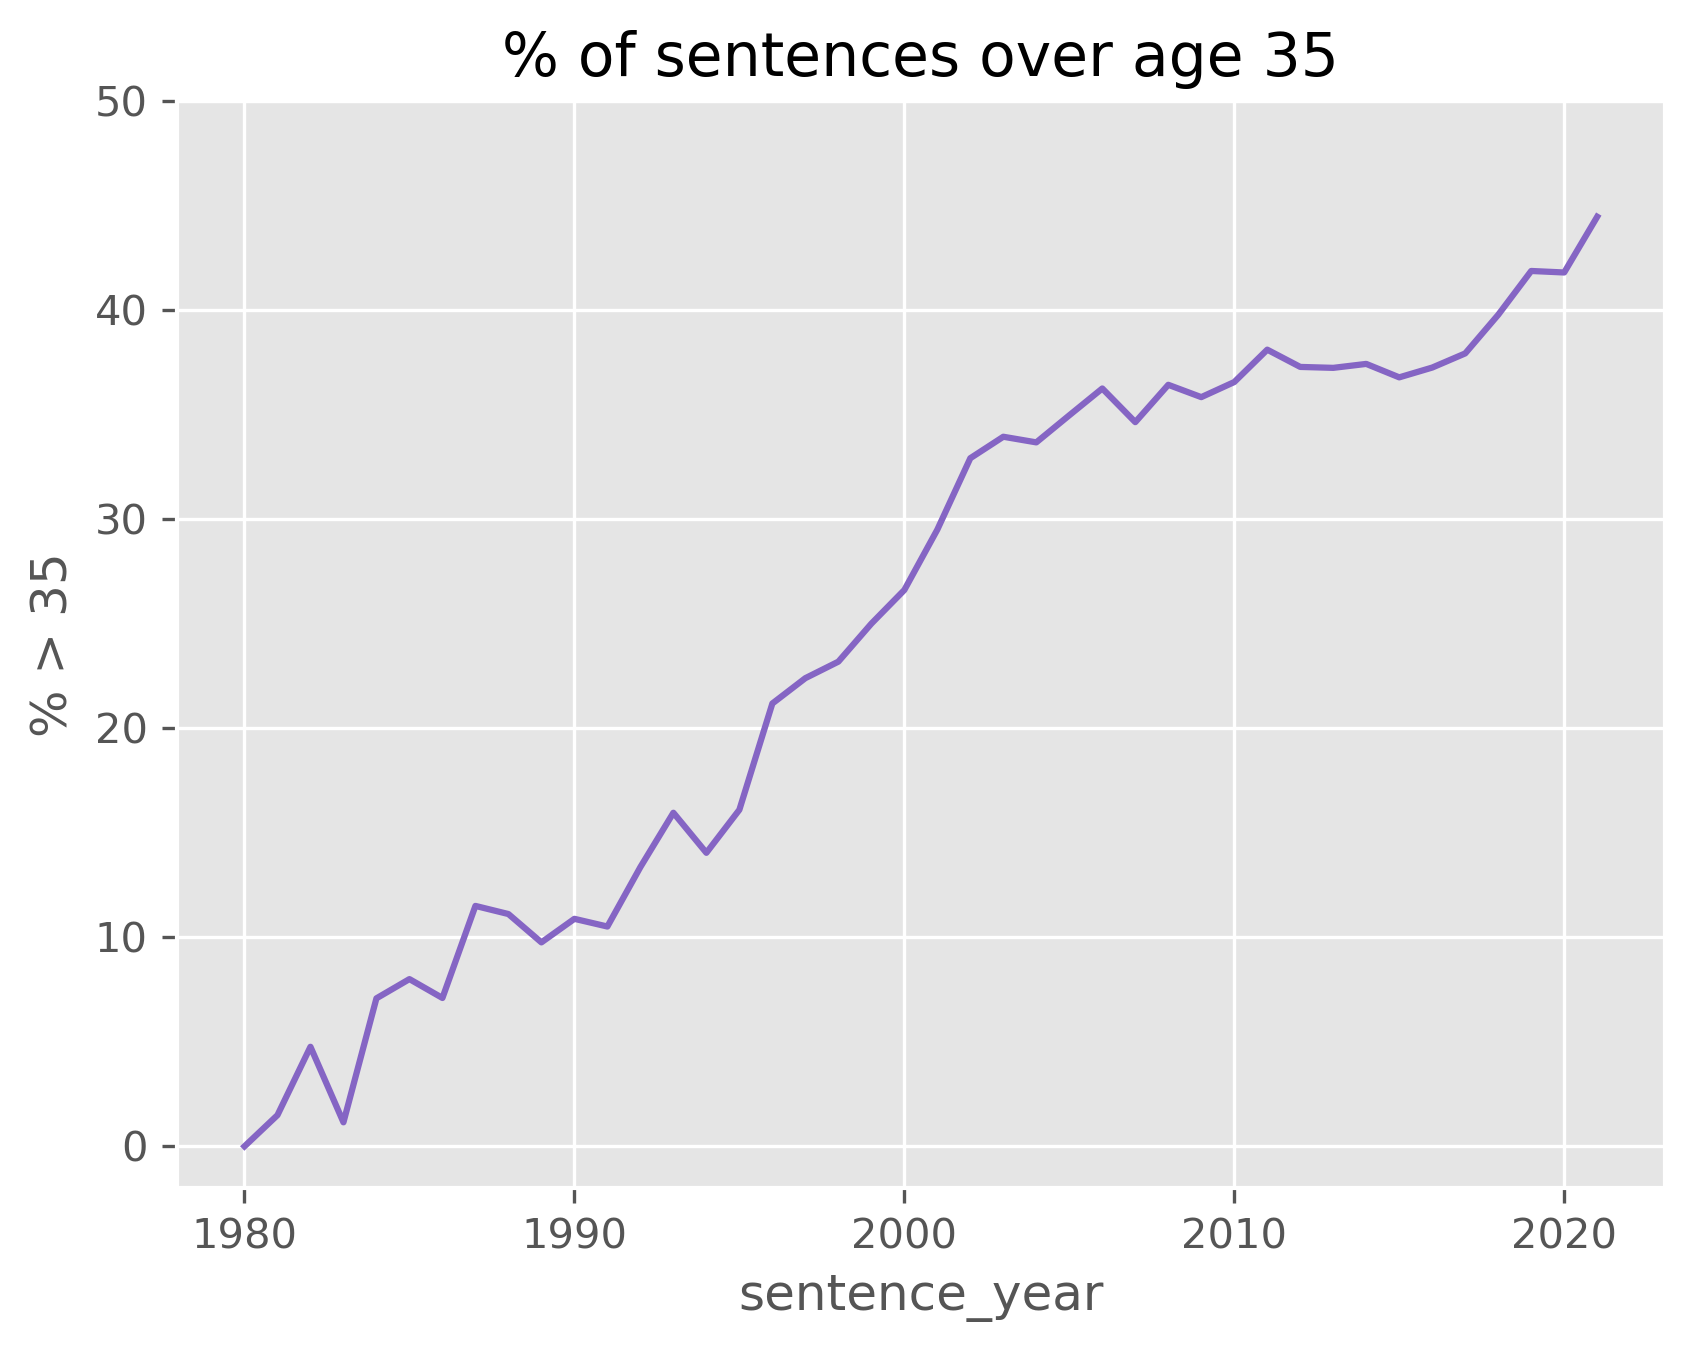

In [21]:
(df
    .query('1980 <= sentence_year <= 2021')
    .groupby('sentence_year')
    .age_at_sentencing
    .agg(lambda x: x.gt(35).mean())
    .multiply(100)
    .plot.line(
        title='% of sentences over age 35', 
        ylim=(-2, 50), 
        ylabel='% > 35', 
        color=SOFT_PURPLE
    )
);

In [22]:
(df
    .query('sentence_year == 2000')
    .age_at_sentencing
    .std()
)

9.168299416804548

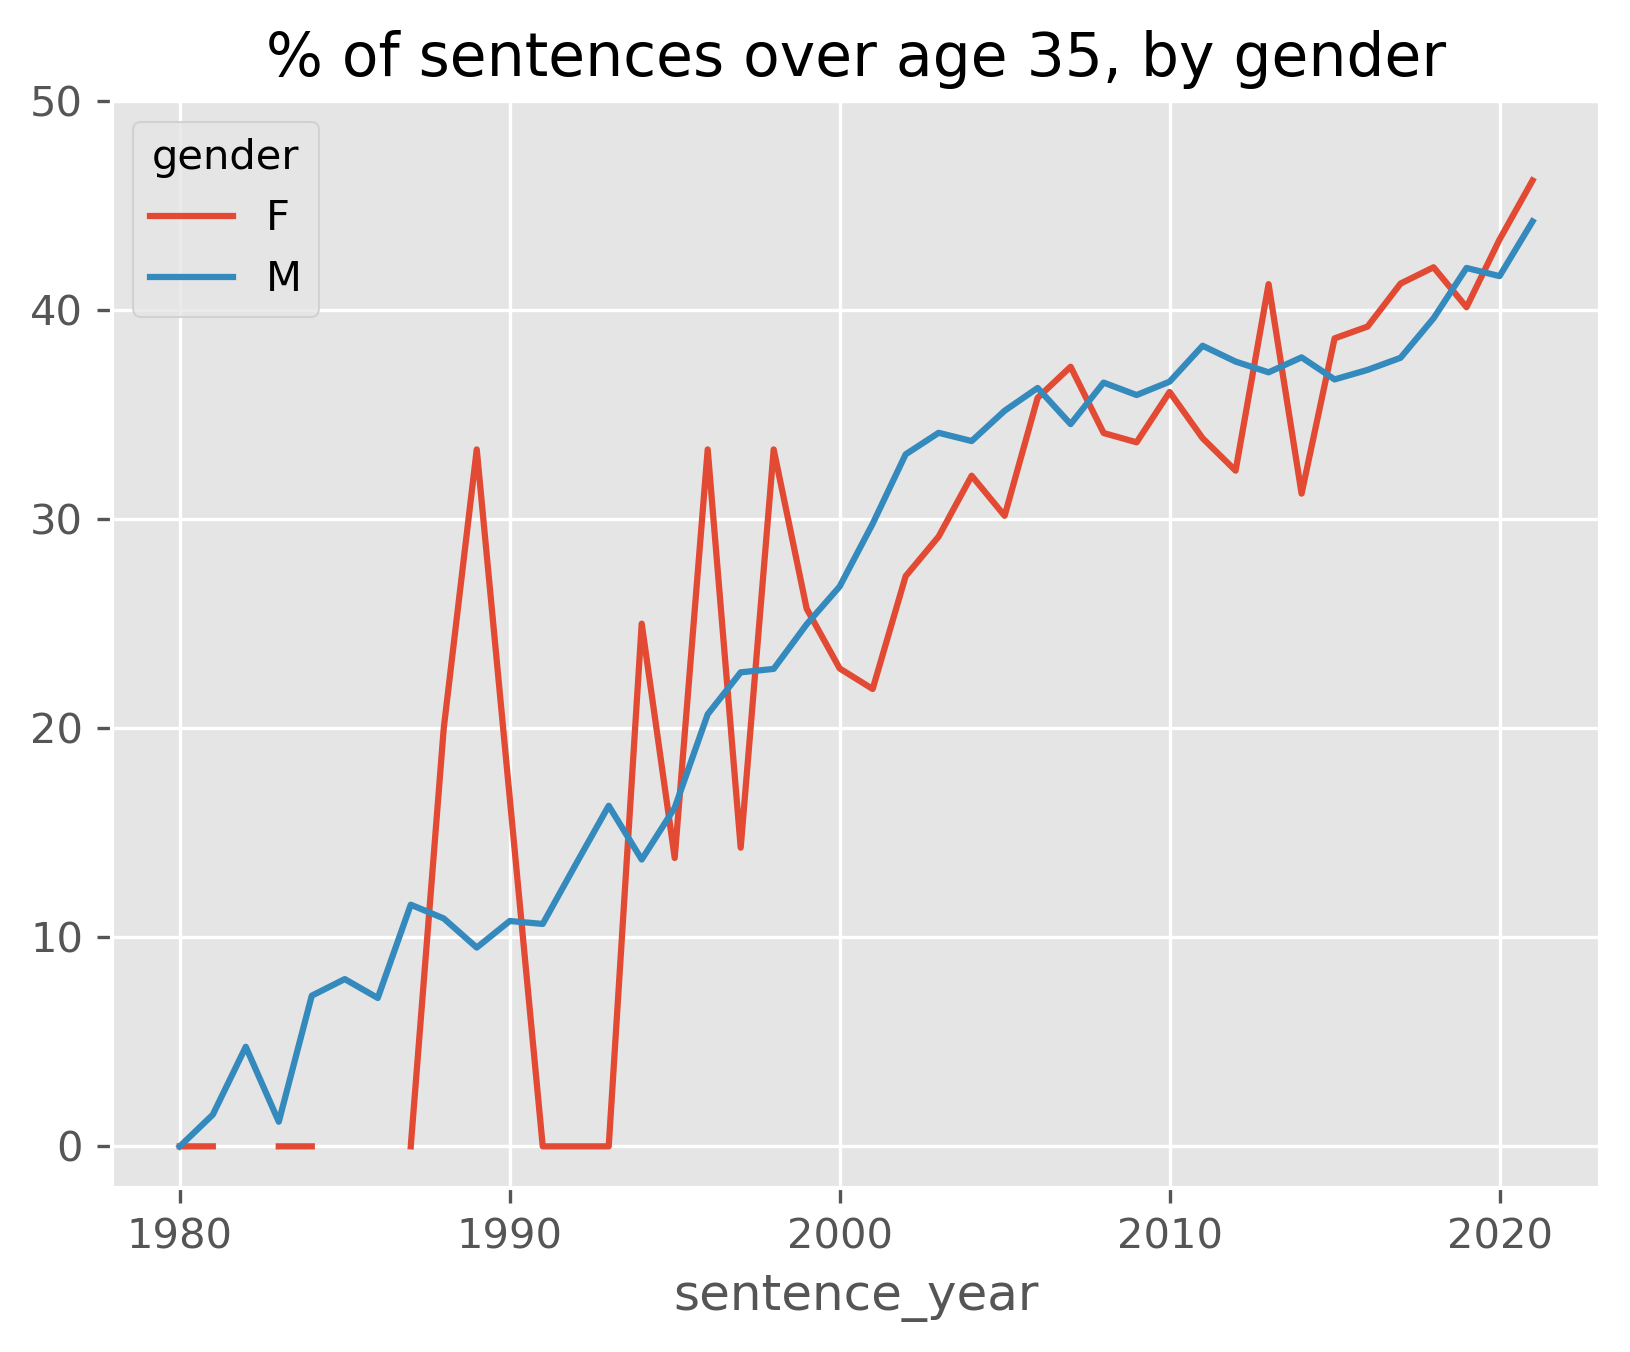

In [23]:
(df
    .query('1980 <= sentence_year <= 2021')
    .pivot_table(
        values='age_at_sentencing',
        index='sentence_year',
        columns='gender',
        aggfunc=lambda x: x.gt(35).mean() * 100
    )
    .plot.line(title='% of sentences over age 35, by gender', ylim=(-2, 50))
);

The effect is present in both genders

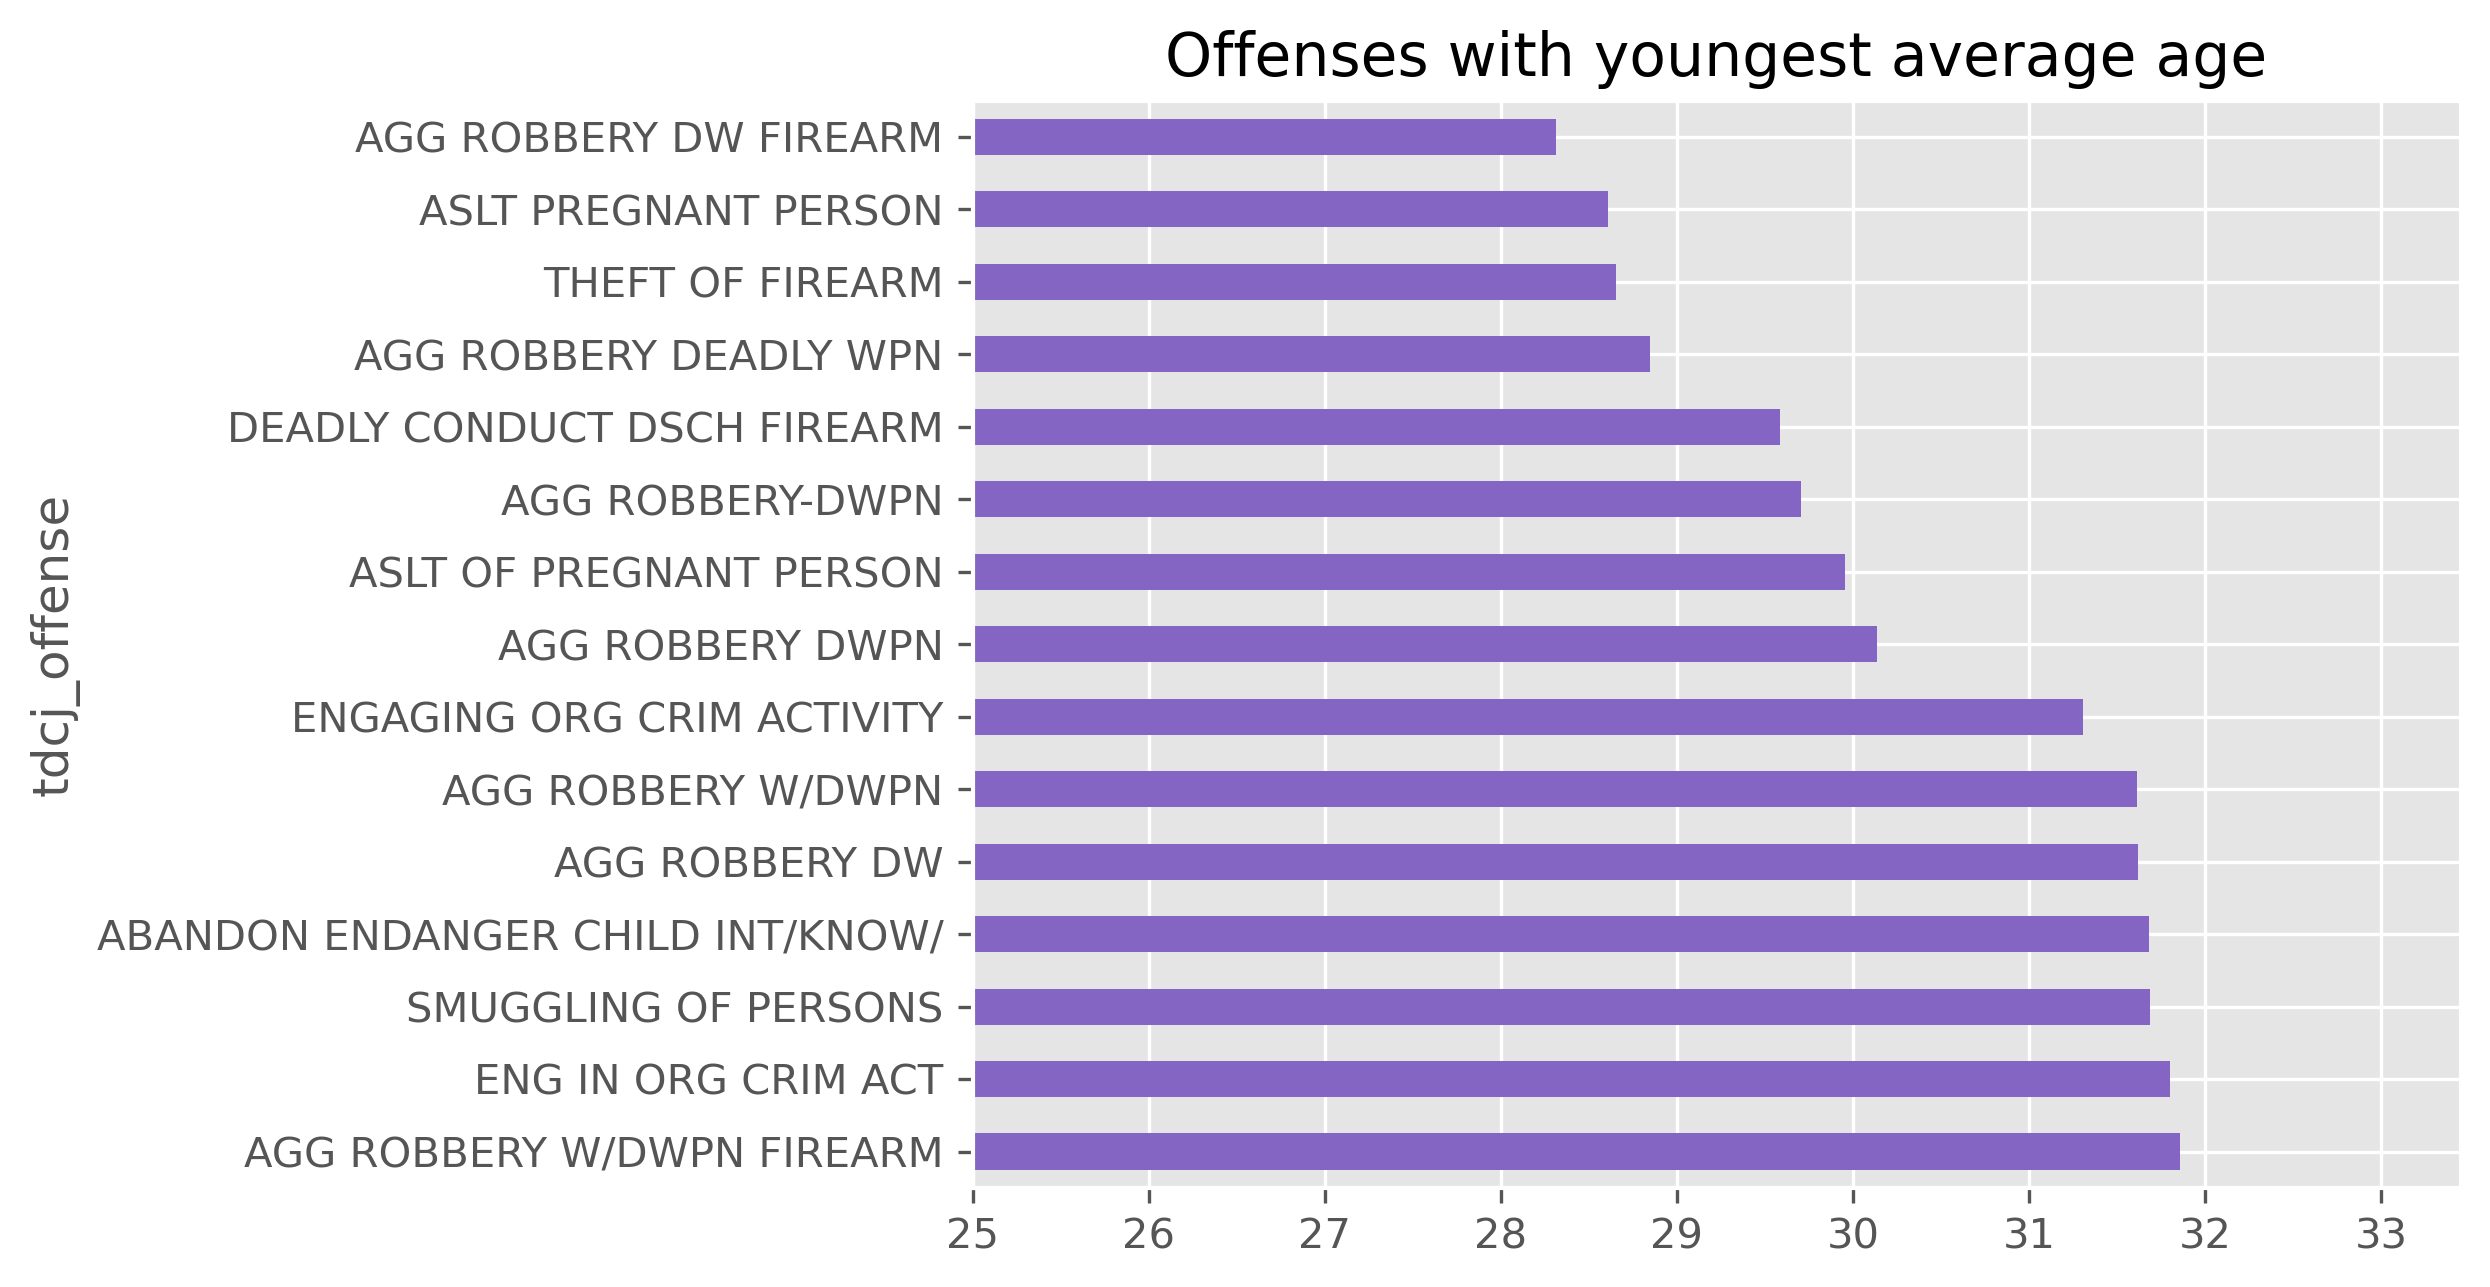

In [24]:
(df
    .groupby('tdcj_offense').filter(lambda df_: len(df_) > 20)
    .groupby('tdcj_offense')
    .aggregate(mean_age=('age', np.mean))
    .sort_values('mean_age', ascending=True)
    .mean_age
    .head(15)
    .sort_values(ascending=False)
    .plot.barh(
        title='Offenses with youngest average age', 
        xlim=(25, None), 
        color=SOFT_PURPLE
    )
);

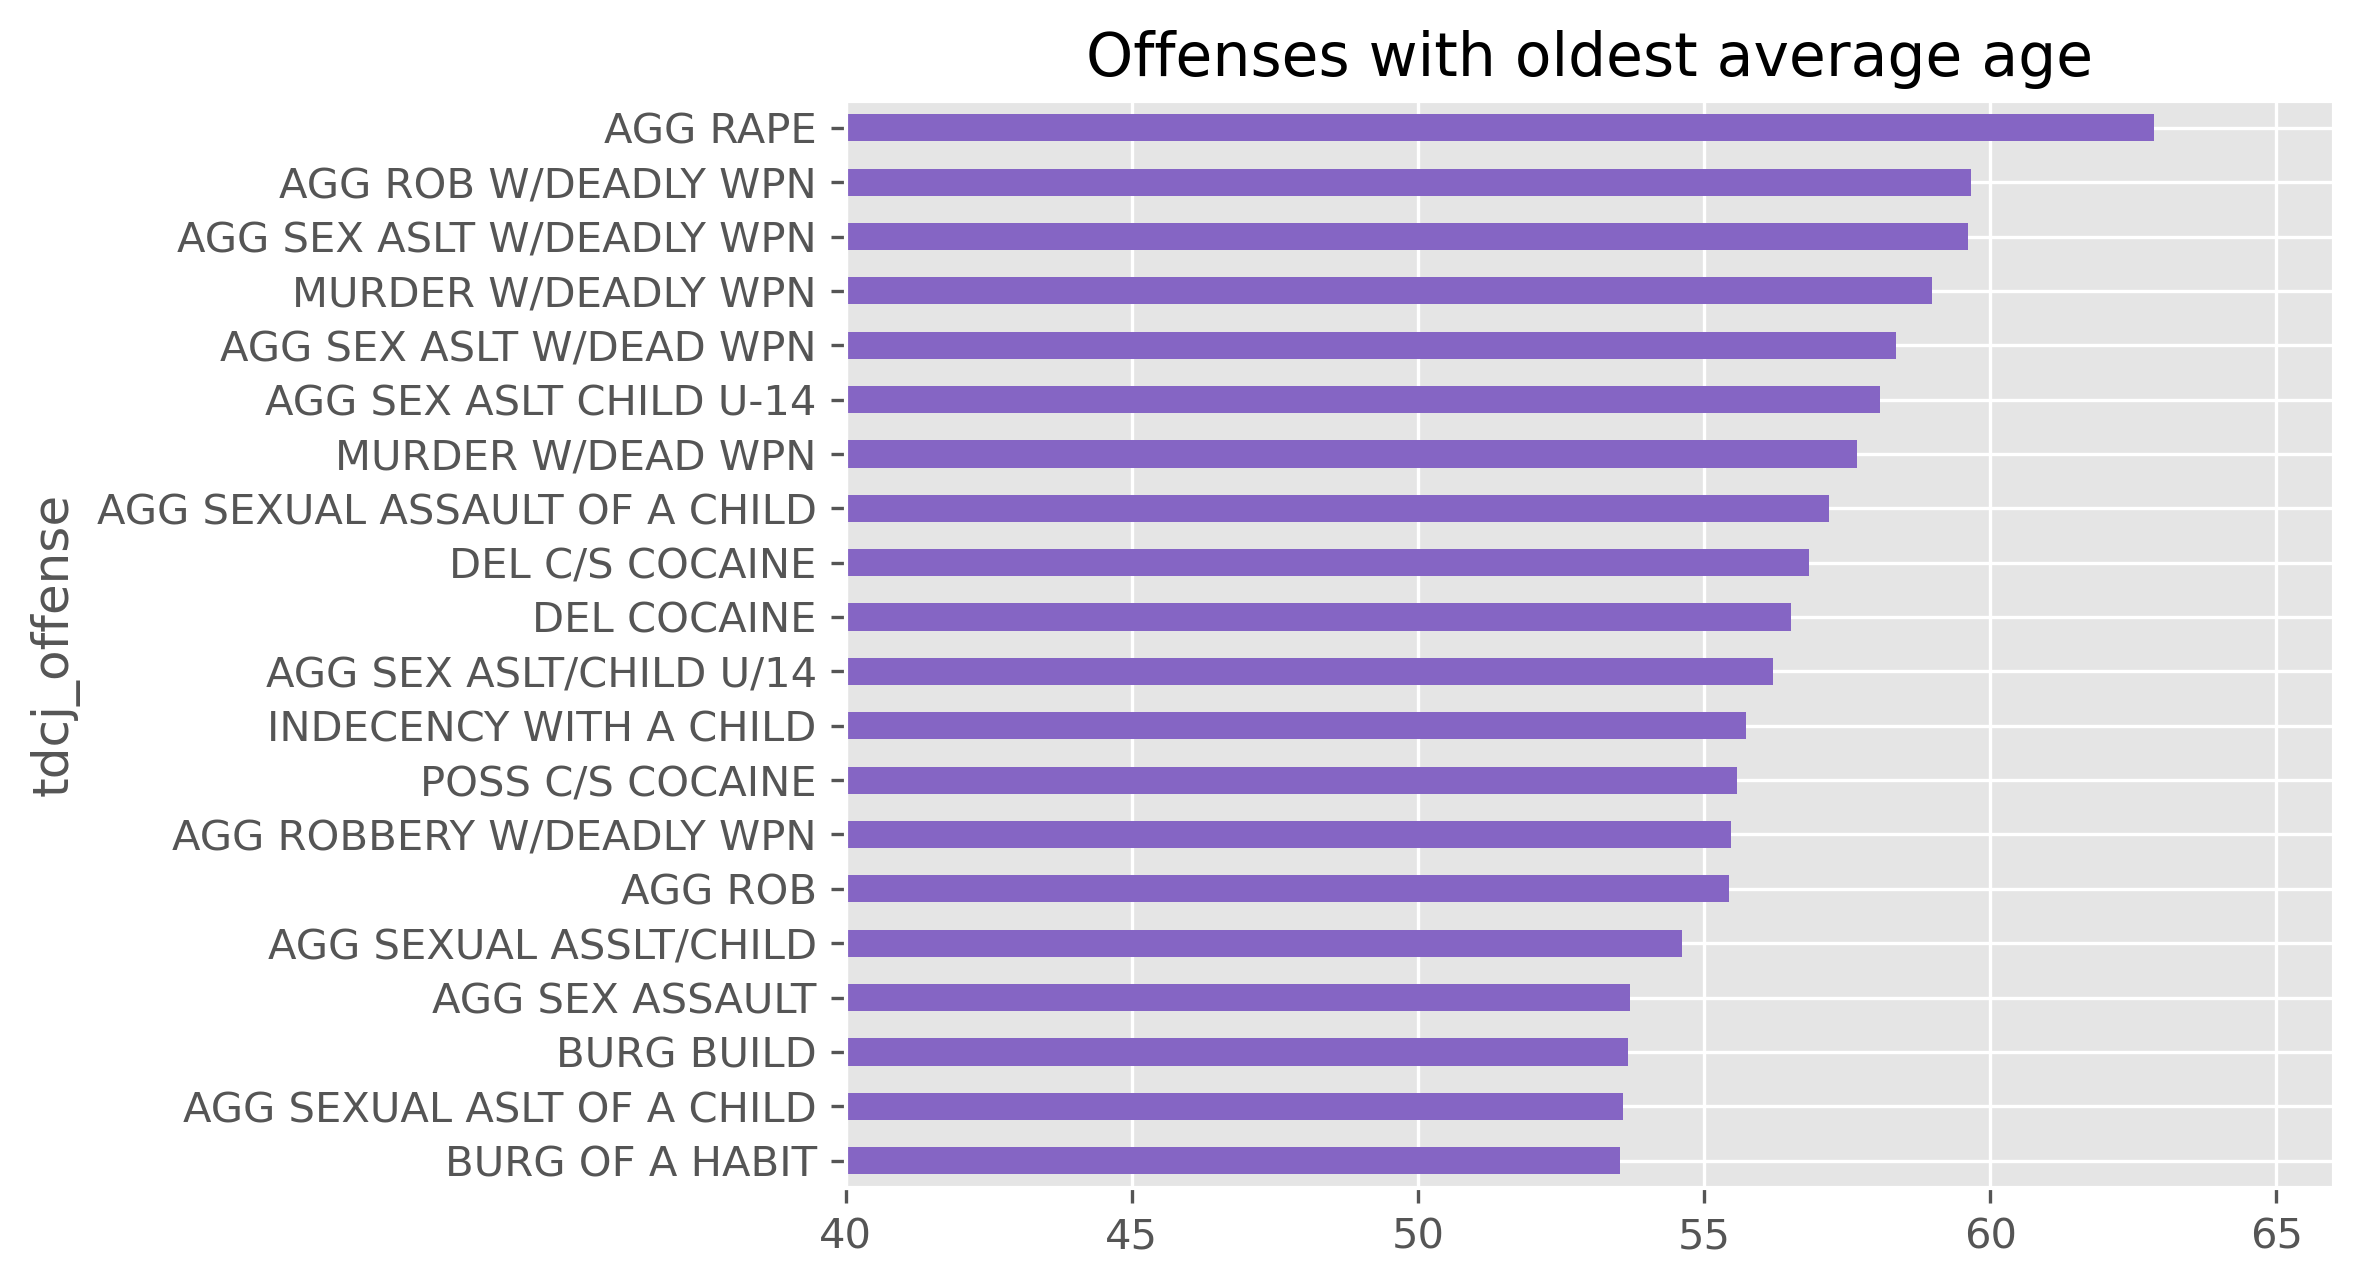

In [25]:
(df
    .groupby('tdcj_offense')
    .agg(
        mean_age=('age', np.mean),
        total=('age', len)
    )
    .query('total > 20')
    .mean_age
    .sort_values()
    .tail(20)
    .plot.barh(
        title='Offenses with oldest average age', 
        xlim=(40, None), 
        color=SOFT_PURPLE
    )
);

In [26]:
df.sample(3).T

,90677,47997,58357
sid_number,8752532,6184403,6794484
tdcj_number,2328622,2267010,2326056
name,"CASEY,MYLES ANDREW","KELLEY,CODY","BARNES,JEREMY DAVID"
current_facility,Sanchez,Cotulla,Byrd
gender,M,M,M
race,white,white,white
age,30,43,37
projected_release,08/11/2023,07/12/2026,04/23/2025
maximum_sentence_date,12/30/2026,07/12/2026,04/23/2025
parole_eligibility_date,10/23/2020,07/12/2022,11/21/2020
